<div class="alert alert-block alert-info">
<b>Projeto III PB</b>
</div>

Este projeto visa construir um modelo de aprendizado de máquina para prever a probabilidade de inadimplência de clientes em potencial da Home Credit, uma instituição financeira que busca ampliar a inclusão financeira. Para isso, diversos conjuntos de dados são fornecidos, cada um com informações relevantes sobre os clientes e seus históricos de crédito.

Os dados abrangem informações de diferentes níveis, desde dados estáticos de cada aplicação de empréstimo até detalhes sobre pagamentos e saldos de créditos anteriores, tanto na Home Credit quanto em outras instituições financeiras.

# Import

In [1]:
# import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import gc

from pathlib import Path
from summarytools import dfSummary
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


import warnings
warnings.filterwarnings("ignore")

In [2]:
# pl.Config.set_tbl_cols(200)
# pl.Config.set_tbl_rows(20)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 70)

# EDA

## Descrição dos Arquivos Fornecidos

> **application_{train|test}.csv**
- Arquivos principais, separados em Treinamento (com TARGET) e Teste (sem TARGET).
- Contêm dados estáticos de cada solicitação de empréstimo. Cada linha corresponde a um empréstimo em nossa base de dados.

> **bureau.csv**
- Reúne todos os créditos anteriores dos clientes reportados ao Birô de Crédito (para quem possui empréstimo em nossa amostra).
- Para cada empréstimo em nossa base, há tantas linhas quantos forem os créditos do cliente informados ao Birô de Crédito antes da data da solicitação.

> **bureau_balance.csv**
- Contém os saldos mensais dos créditos registrados no Birô de Crédito.
- Cada linha representa um mês de histórico de um crédito anterior informado ao Birô, ou seja, (# empréstimos na base * # créditos anteriores relevantes * # meses de histórico disponível).

> **POS_CASH_balance.csv**
- Fornece históricos mensais de saldos de empréstimos POS (ponto de venda) e de empréstimos em dinheiro que o cliente teve junto à Home Credit.
- Há uma linha para cada mês de histórico de cada crédito anterior na Home Credit (crédito ao consumidor e empréstimos em dinheiro) relacionado aos empréstimos da amostra. Isso significa (# empréstimos na base * # créditos anteriores relevantes * # meses de histórico disponível).

> **credit_card_balance.csv**
- Reúne históricos mensais de saldos de cartões de crédito que o cliente possuiu na Home Credit.
- Cada linha representa um mês de histórico de cada crédito anterior (cartão de crédito, crédito ao consumidor ou empréstimo em dinheiro) relacionado aos empréstimos em nossa amostra, no mesmo formato de contagem anterior.

> **previous_application.csv**
- Lista todas as solicitações anteriores de empréstimo na Home Credit para clientes presentes em nossa amostra.
- Cada linha equivale a uma aplicação anterior associada aos empréstimos analisados.

> **installments_payments.csv**
- Traz o registro de todos os pagamentos de créditos anteriores na Home Credit relacionados à nossa amostra.
- Cada linha corresponde a um pagamento efetuado ou em atraso. Ou seja, cada pagamento de prestação ou parcela não paga referente a um crédito anterior também faz parte do conjunto.

> **HomeCredit_columns_description.csv**
- Descreve cada coluna dos diferentes arquivos de dados, fornecendo informações adicionais sobre o significado e formato dos campos.

<h2> Database Schema </h2>

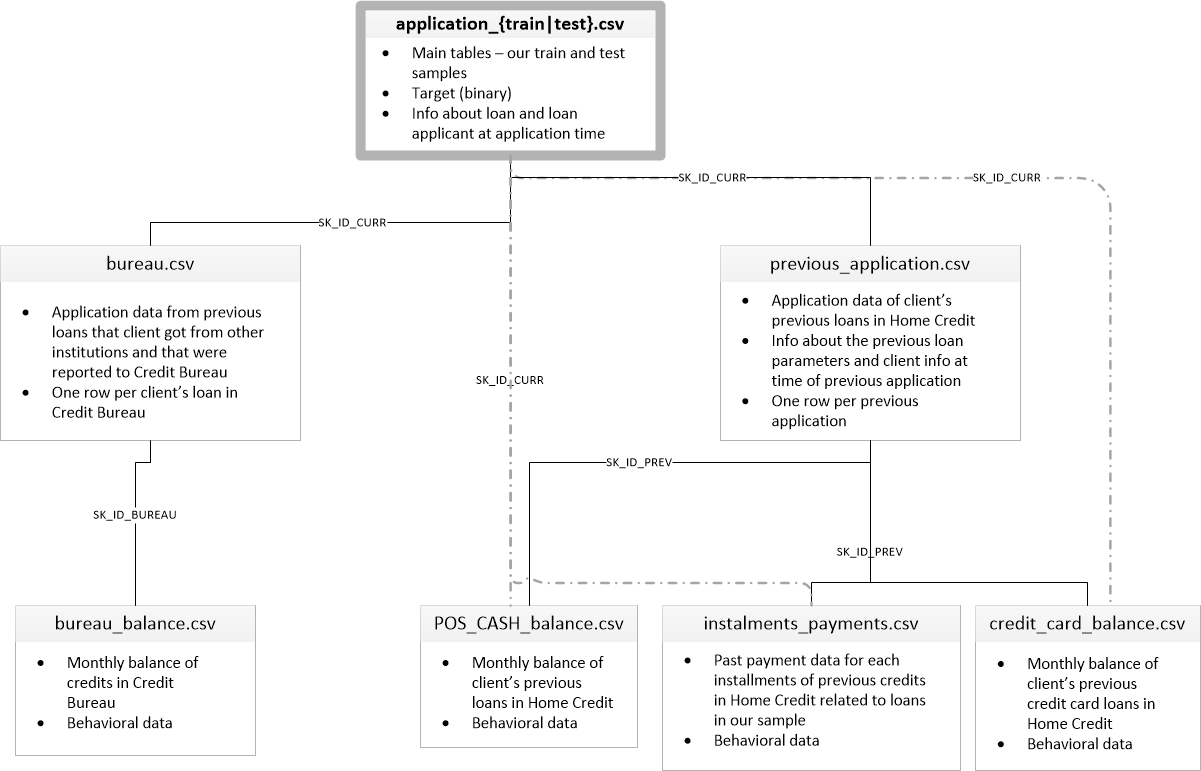

## Primeiros Registros

In [3]:
def reduce_memory_usage(df: pd.DataFrame, convert_obj_to_cat: bool = True, convert_dates: bool = True, use_unsigned: bool = True) -> pd.DataFrame:
    """
    Otimiza o uso de memória em um DataFrame realizando downcasting de colunas numéricas
    e, opcionalmente, convertendo colunas de texto para 'category' e colunas de datas para 
    datetime64. As conversões são feitas diretamente no DataFrame de entrada.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame a ser otimizado.
    convert_obj_to_cat : bool, opcional, default True
        Se True, colunas do tipo object são analisadas e convertidas para 'category'
        caso tenham alta repetição de valores (baixa cardinalidade).
    convert_dates : bool, opcional, default True
        Se True, tenta converter colunas reconhecidas como datas/horários para datetime64.
    use_unsigned : bool, opcional, default True
        Se True, utiliza tipos unsigned (uint8, uint16, etc.) para colunas sem valores negativos.

    Retorna
    -------
    pd.DataFrame
        O próprio DataFrame de entrada, porém com tipos de colunas otimizados.

    Observações
    ----------
    1. Se houver colunas com valores ausentes (NaN) que sejam do tipo numérico,
       a conversão para tipo inteiro pode falhar ou ser forçada para float. 
       Caso deseje manter comportamento de 'inteiro com NA', considere o uso dos
       tipos 'Int8', 'Int16', etc. do pandas (com 'I' maiúsculo).
    2. Colunas convertidas para 'category' podem perder a ordem de strings
       (se houver necessidade de uso posterior de ordenamento alfanumérico).
    3. Se as colunas já tiverem algum tipo de conversão posterior planejada
       (por exemplo, encoding específico), avalie se a conversão para 'category'
       é desejada neste momento.
    """

    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memória usada antes da redução: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        # 1. Tentativa de conversão para datetime
        if convert_dates and col_type == object:
            try:
                df[col] = pd.to_datetime(df[col], errors='raise')
                continue  # Se converteu para datetime, pula para a próxima coluna
            except (ValueError, TypeError):
                pass

        # 2. Conversão para category se for texto e estiver habilitado
        if col_type == object and convert_obj_to_cat:
            num_unique_values = df[col].nunique(dropna=False)
            num_total_values = len(df[col])
            # Exemplo de heurística simples: se menos de 50% dos valores são únicos convertemos para 'category'
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
            continue

        # 3. Downcasting de colunas numéricas
        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            # Verifica se há valores ausentes, pois pode impedir conversão p/ int
            has_na = df[col].isnull().any()

            # Tentativa de uso de inteiros ou floats
            if pd.api.types.is_integer_dtype(df[col]) and not has_na:
                # Decidir entre signed/unsigned
                if use_unsigned and c_min >= 0:
                    if c_max <= np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max <= np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max <= np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)
            else:
                # Downcast de float (ou int com NA) para float16, float32 ou float64
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memória usada após otimização: {end_mem:.2f} MB")
    print(f"Redução de {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df

In [4]:
# Carregando os Dados (Com Otimização de Memória)

# df_train = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "application_train.csv")))
# print("-+-" * 10)
# df_bureau_balance = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "bureau_balance.csv")))
# print("-+-" * 10)
# df_bureau = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "bureau.csv")))
# print("-+-" * 10)
# df_credit_card = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "credit_card_balance.csv")))
# print("-+-" * 10)
# df_installments_payments = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "installments_payments.csv")))
# print("-+-" * 10)
# df_pos_cash_balance = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "POS_CASH_balance.csv")))
# print("-+-" * 10)
# df_previous_application = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "previous_application.csv")))

In [ ]:
df_train = pd.read_csv(Path("data", "01_raw", "application_train.csv"))
df_bureau_balance = pd.read_csv(Path("data", "01_raw", "bureau_balance.csv"))
df_bureau = pd.read_csv(Path("data", "01_raw", "bureau.csv"))
df_installments_payments = pd.read_csv(Path("data", "01_raw", "installments_payments.csv"))

# df_credit_card = pd.read_csv(Path("data", "01_raw", "credit_card_balance.csv"))
# df_pos_cash_balance = pd.read_csv(Path("data", "01_raw", "POS_CASH_balance.csv"))
# df_previous_application = pd.read_csv(Path("data", "01_raw", "previous_application.csv"))

### df_train

In [6]:
print(df_train.shape)
df_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
df_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

**Análise:** 

Foi identificado que a maior parte das variáveis apresenta valores nulos. Em relação ao tipo de dado, elas já estão alinhadas ao dicionário de dados, com exceção de **`DAYS_BIRTH`**, **`DAYS_EMPLOYED`**, **`DAYS_REGISTRATION`**, **`DAYS_ID_PUBLISH`** e **`DAYS_LAST_PHONE_CHANGE`**, que apresentam valores negativos e demandam transformação em valores absolutos. Tendo isso em vista, vamos dar prioridade ao tratamento de valores ausentes em um primeiro momento.

#### Valores Ausentes

In [8]:
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Gera um sumário de valores ausentes (NaNs) em cada coluna de um DataFrame.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame a ser analisado.

    Retorno
    -------
    pd.DataFrame
        DataFrame contendo a contagem e o percentual de valores ausentes
        para cada coluna que apresente ao menos um valor ausente, ordenado
        do maior para o menor percentual de ausentes.

    Observações
    -----------
    - É exibido na tela um resumo informando o número de colunas com valores ausentes.
    - Somente as colunas que apresentam valores ausentes são retornadas na tabela.
    """

    # Número total de linhas do DataFrame
    nrows = len(df)

    # Contagem de valores ausentes por coluna
    mis_val = df.isnull().sum()

    # Percentual de valores ausentes
    mis_val_percent = 100 * mis_val / nrows

    # Concatenando as duas informações em um único DataFrame
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Renomeando as colunas
    mis_val_table.columns = ['Valores Ausentes', '% dos Valores Totais']

    # Filtrando apenas colunas com valores ausentes e ordenando
    mis_val_table = (
        mis_val_table[mis_val_table['% dos Valores Totais'] != 0]
        .sort_values('% dos Valores Totais', ascending=False)
        .round(1)
    )

    # Exibindo um resumo
    print(
        f"O dataframe selecionado tem {df.shape[1]} colunas.\n"
        f"Existem {mis_val_table.shape[0]} colunas com valores ausentes."
    )

    return mis_val_table

In [9]:
# Análise de Percentual dos valores Ausentes
valores_ausentes_train_df = missing_values_table(df_train)
valores_ausentes_train_df = valores_ausentes_train_df[valores_ausentes_train_df["% dos Valores Totais"] >= 40]
valores_ausentes_train_df

O dataframe selecionado tem 122 colunas.
Existem 67 colunas com valores ausentes.


,Valores Ausentes,% dos Valores Totais
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [10]:
num_missing = len(valores_ausentes_train_df)
total_columns = len(df_train.columns)
perc_missing = num_missing / total_columns * 100

print(f"{num_missing} colunas possuem valores ausentes de um total de {total_columns} colunas, representando aproximadamente {perc_missing:.2f}%")

49 colunas possuem valores ausentes de um total de 122 colunas, representando aproximadamente 40.16%


In [11]:
# Exclua a coluna de identificação primária para checagem de duplicatas
cols_without_pk = [col for col in df_train.columns if col != 'SK_ID_CURR']

# Identifica as linhas duplicadas com base nas colunas selecionadas
duplicated_rows = df_train[df_train.duplicated(subset=cols_without_pk, keep='first')]

# Exibe a quantidade e os primeiros registros duplicados
print(f"Quantidade de duplicadas (exceto 'SK_ID_CURR'): {len(duplicated_rows)}")
print(duplicated_rows.head())

Quantidade de duplicadas (exceto 'SK_ID_CURR'): 0
Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AV

In [12]:
# Check IDs duplicados
duplicate_ids = df_train['SK_ID_CURR'][df_train['SK_ID_CURR'].duplicated(keep=False)]
duplicates_counts = duplicate_ids.value_counts()
print(duplicates_counts)

Series([], Name: count, dtype: int64)


**Resultado da Análise**: Não existem colunas duplicadas e os IDs também não consta duplicação.

#### Análise com Symarytools

In [13]:
summary_train = dfSummary(df_train)
summary_train

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,SK_ID_CURR[int64],Mean (sd) : 278180.5 (102790.2)min < med < max:100002.0 < 278202.0 < 456255.0IQR (CV) : 177997.0 (2.7),"307,511 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACIklEQVR4nO3YvW7iQBSG4Rkg0QQQFj+BjiblSltYouECUuZicwtIFFtTpElFh2RZRkwSYbFeOdpmm8RjE7Kf9D41hzOId4wSWxSFAf53re8+AFBFp9KrIMNae2OMua45fiyK4tUohtrwg5dP7N81Z5vOq+5uMutGo9F9FEW9OsP7/T611j7WjfUrL0nns8Xj8fhhMBgMQ7eeTqcr7/1dv99/brVa+SXnVXc3PXee584Y82OxWPyaTCb7kNksy9xqtZomSTKx1gbNXuKSfPZEvS4jXS6Xr1EUvYUs3m63w81mcxvH8dNsNkuDTt1wXnX3mc7ddc7l0+n0JWTWe3+V5/nP+XzebrfbQd/1OS7Jer0eJklSPo1rhfqujDT0g6dpWv4MmF6vFzzbdF5197nOXcfxeOw457pxHL9d+pL89eHZ+WMK//iOS1IF/56CBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFhE6VF2VZ5kLf+HA4vM94791ut+tecl51t+q5TcP5Kn39ASCxP3B3DrF4AAAAAElFTkSuQmCC"">",0(0.0%)
2,TARGET[int64],Mean (sd) : 0.1 (0.3)min < med < max:0.0 < 0.0 < 1.0IQR (CV) : 0.0 (0.3),2 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABp0lEQVR4nO3XUWqrQBiGYecQQnujBMHFuIgutotwN1LiRVMKiYdZQGhiG3q+w/Pc6j/Mxcs4lnVdG/jX/fntDcAtdl+9UEp5bppm32zzua7raeMs3BZqjbTv+5e2bQ/NBsuyvJVSXsXKo0/UfY10HMdT13Uf9yx8PB6fpmk6zPNcT2Oh8thPf1UjHYbhfcP69doA3+ZnighCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIu9/eAP+PUspz0zT7jeOf67qerj0UKj8Wad/3L23bHrbML8vyVkp5vRarUPkp+xrpOI6nrus+7hk8Ho9P0zQd5nmup7FQebwa6TAM7xtG67XhKj9TRBAqEXa33iHuXbjOnM/nun5bStm0OaK0l8tlt7WVr176C3clTn17e5CVAAAAAElFTkSuQmCC"">",0(0.0%)
3,NAME_CONTRACT_TYPE[object],1. Cash loans2. Revolving loans,"278,232 (90.5%)29,279 (9.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABNUlEQVR4nO3bMWrDMABGYamY0iw2weDD+BA9bA/h25hgDU3poqKhY6GVkkdqv2/IZqLhkZCgP+acg0SIIYRTCOEZeTftwWfO+VrzYDeO42vf9+fbn0l7lFK6xBjfaoLrSmjzPF+HYfi4z/G0F9u2vSzLcl7XtXwT/j228lJCm6bp/S4n1N6cah98uu05pJ8ZmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJkz3fSmOe0v9V62ddOWab7l92XIpTseRUrqUHULNsw5ehA1eolM+UVo/2aor1/E0TflaZl06nuopX+usS8fTOuXzF6x+zT91hTE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNjz/lc/4ndMrXMuvS8Th4UaB8AQpbat84wdJ2AAAAAElFTkSuQmCC"">",0(0.0%)
4,CODE_GENDER[object],1. F2. M3. XNA,"202,448 (65.8%)105,059 (34.2%)4 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bMU5bQRSG0TvICkljC1nyEsgevIgsNovwIrIHC/kVIdA8NEqFUlDxm1zOKWhnkD+957HmjnVdCxJuIqtAVY2q+lZVX669Ef7xvK7rYzWy2e/3P7bb7d21N8Jry7I8jDF+dgpuM0M7Ho+Pu93uz7U3w1+Xy+Xr6XS6O5/P843TJ7b5Z4Z2OBx+X3szvDK/3rTigECM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiN7BWjeX8qtyRv6fp5bOaN0HlRr+P9qf/ZsiwP82p4NWIG4eN67nQlfBpG+Ujp+mRr91TooOV0VcfJpA7aTVd1nUzqoOt0lZP1B+RHXWLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEtJuu6vS/dNNyuqrjZFIHZhCIMV1FjAMCMWIj5maM8X2M4QRH5Ml2X1W3778Un53XKDFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjG9quqnnJL8lmZriLGa5RKeQHnRXM6aRUq2AAAAABJRU5ErkJggg=="">",0(0.0%)
5,FLAG_OWN_CAR[object],1. N2. Y,"202,924 (66.0%)104,587 (34.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO

### df_bureau_balance & df_bureau

In [14]:
print(df_bureau_balance.shape)
df_bureau_balance.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [15]:
df_bureau_balance.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   SK_ID_BUREAU    27299925 non-null  int64 
 1   MONTHS_BALANCE  27299925 non-null  int64 
 2   STATUS          27299925 non-null  object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [16]:
print(df_bureau.shape)
df_bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [17]:
df_bureau.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_CURR              1716428 non-null  int64  
 1   SK_ID_BUREAU            1716428 non-null  int64  
 2   CREDIT_ACTIVE           1716428 non-null  object 
 3   CREDIT_CURRENCY         1716428 non-null  object 
 4   DAYS_CREDIT             1716428 non-null  int64  
 5   CREDIT_DAY_OVERDUE      1716428 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     1610875 non-null  float64
 7   DAYS_ENDDATE_FACT       1082775 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  591940 non-null   float64
 9   CNT_CREDIT_PROLONG      1716428 non-null  int64  
 10  AMT_CREDIT_SUM          1716415 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     1458759 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    1124648 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  1716428 non-null  float64
 14  CR

**Resultado:**

No conjunto de dados do bureau, constatamos que a maioria das variáveis apresenta poucos valores ausentes, em contraste com o dataset de solicitações, que possui diversas lacunas. Algumas variáveis importantes – por exemplo, **`AMT_ANNUITY`**, **`DAYS_CREDIT_ENDDATE`** e **`AMT_CREDIT_MAX_OVERDUE`** – podem ter muitos dados faltantes; contudo, essa ausência pode indicar que os clientes não tiveram problemas significativos de crédito anteriormente.

Além disso, vale ressaltar que o saldo do bureau (bureau_balance) não apresenta valores ausentes e os tipos de dados estão em conformidade com o dicionário fornecido.

#### Valores Ausentes

In [18]:
# Análise de Percentual dos valores Ausentes
valores_ausentes_bureau = missing_values_table(df_bureau)
valores_ausentes_bureau = valores_ausentes_bureau[valores_ausentes_bureau["% dos Valores Totais"] >= 40]
valores_ausentes_bureau

O dataframe selecionado tem 17 colunas.
Existem 7 colunas com valores ausentes.


,Valores Ausentes,% dos Valores Totais
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5


In [19]:
num_missing = len(valores_ausentes_bureau)
total_columns = len(df_bureau.columns)
perc_missing = num_missing / total_columns * 100

print(f"{num_missing} colunas possuem valores ausentes de um total de {total_columns} colunas, representando aproximadamente {perc_missing:.2f}%")

2 colunas possuem valores ausentes de um total de 17 colunas, representando aproximadamente 11.76%


Para cada coluna, é fundamental avaliar não só a quantidade de dados ausentes, mas também a sua relevância para o desempenho do modelo. Quando uma coluna apresenta um percentual elevado de valores faltantes, aplicar técnicas de imputação pode resultar em dados pouco confiáveis ou até enviesados.

Assim, é importante identificar essas colunas por exemplo, aquelas com mais de 40% ou 50% de ausências para decidir se vale a pena imputá-las ou se é melhor descartá-las do conjunto de variáveis.

Esse processo garante que o modelo seja treinado com dados de qualidade e que os esforços de tratamento estejam direcionados para colunas com maior potencial informativo.

> **Análise de Valores Ausentes em Dados de Crédito**

A seguir, analisamos algumas variáveis do conjunto de dados relacionadas a créditos, destacando a quantidade de valores não nulos e a possível interpretação dos dados ausentes.

---

> 1. DAYS_CREDIT_ENDDATE (1.610.875 valores não nulos de 1.716.428)

* **Possível Mecanismo de Ausência:** MNAR (Missing Not At Random) ou MAR (Missing At Random)
* **Interpretação:**  
    - **MNAR:** A ausência do valor pode indicar que o crédito ainda está ativo, e a data de término prevista não foi definida.
    - **MAR:** Os dados podem ter sido omitidos aleatoriamente durante a coleta, sem relação direta com o valor em si.

---

> 2. DAYS_ENDDATE_FACT (1.082.775 valores não nulos)

* **Possível Mecanismo de Ausência:** MNAR  
* **Interpretação:**  
    - A variável registra a data final real do crédito. A ausência deste valor sugere que o empréstimo ainda está em aberto, estando diretamente relacionada ao status do crédito.

---

> 3. AMT_CREDIT_MAX_OVERDUE (591.940 valores não nulos)

* **Possível Mecanismo de Ausência:** MNAR  
* **Interpretação:**  
    - Representa o valor máximo de atraso registrado. A falta de registro pode indicar que o cliente nunca teve atraso significativo no pagamento, sugerindo que a ausência está relacionada à performance do pagamento.

---

> 4. AMT_CREDIT_SUM (1.716.415 valores não nulos)

* **Possível Mecanismo de Ausência:** MAR ou MCAR (Missing Completely At Random)  
* **Interpretação:**  
    - Geralmente é esperado que o total do crédito seja informado. Se faltar, pode ser fruto de erros de entrada ou omissão acidental, sendo menos provável que esteja relacionado a uma característica do próprio cliente (MCAR) ou esteja dependente de outros fatores observados (MAR).

---

> 5. AMT_CREDIT_SUM_DEBT (1.458.759 valores não nulos)

* **Possível Mecanismo de Ausência:** MNAR  
* **Interpretação:**  
    - Indica o montante da dívida remanescente. Em casos de crédito totalmente quitado, a ausência ou valor zero pode ser esperada, refletindo uma dependência direta do status de pagamento do empréstimo.

---

> 6. AMT_CREDIT_SUM_LIMIT (1.124.648 valores não nulos)

* **Possível Mecanismo de Ausência:** MNAR  
* **Interpretação:**  
    - Registra o limite do crédito. Sua ausência pode ocorrer em produtos financeiros que não definem um limite fixo, evidenciando características específicas do produto.

---

> 7. AMT_ANNUITY (489.637 valores não nulos)

* **Possível Mecanismo de Ausência:** MNAR  
* **Interpretação:**  
    - Trata dos valores das anuidades. A ausência deste dado pode indicar que o empréstimo não possui um calendário de pagamentos com anuidade (por exemplo, quando o pagamento é único), estando fortemente ligada à modalidade do crédito.

---

**Resumo dos Mecanismos de Dados Faltantes:**

- **MCAR (Missing Completely At Random):**  
    - A ausência dos dados ocorre aleatoriamente, sem relação com outras variáveis.  
    - *Exemplo:* Ocasionalmente, um dado pode estar faltando por erro de digitação ou omissão acidental.

- **MAR (Missing At Random):**  
    - A falta dos valores está relacionada a outras características observáveis, embora não ao próprio valor ausente.  
    - *Exemplo:* Clientes com renda mais alta podem ter maior probabilidade de não informar determinados detalhes por questões de confidencialidade, mas isso pode ser correlacionado a outras variáveis coletadas.

- **MNAR (Missing Not At Random):**  
    - A ausência está diretamente relacionada ao valor que falta, podendo indicar um comportamento ou status subjacente do cliente.  
    - *Exemplo:* Clientes com histórico de atraso prolongado podem ter dados ausentes justamente por não terem apresentado um valor de atraso definido.

#### Análise com Symarytools

In [20]:
summary_bureau_balance = dfSummary(df_bureau_balance)
summary_bureau_balance

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,SK_ID_BUREAU[int64],Mean (sd) : 6036297.3 (492348.9)min < med < max:5001709.0 < 6070821.0 < 6842888.0IQR (CV) : 701018.0 (12.3),"817,395 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACqUlEQVR4nO3cvW7aUByG8eNCggvIFh+CjRuI1AGJxRfQsRfbS8jAkJk7YENCFgg3yMa4cqRKaYcEfwDndZ/fHBMkHhn8Pz52siwzgO2+3PsNAJdoX/RXKMRxnK/GmMeSh8dZlr3W/JbkEeoVIh2NRj88zxuUOX6/34eO4/wk1r8Rav0e80iDIHj1ff9Y5MDdbucul8vBdrvNz8aE+g6hXkke6WQy+VXi0PxnA/7BxRQkECokECokECokECokECokECokMEe1TJqmD8YYz3Gcsi8RN3FVi1AtEkXRQ5Ik32azWavVahVa1Wr6EiyhWiSO47brut35fH6cTqdh0eN3DV6CJVQL9Xq9ssuvjV2C5WIKEggVEvjqR103fF914kCoDZOWH2+5w+Hwu+/7vbL/+5oTB0Kt/+zinc/nPBap8VaSJK4x5mmxWLyMx+O9bRMHQq15O0n+gadp+nQ8Hp+NMWWv3G8+3lqv14PVatV1XTexceJAqDVvJ/nzgZ9Op5YRGm+FYWj1WItQa95OYvsHrorxFCRwRoUtN9R8ONoiVFhxQ81noy1Cxd0nDpeMtggVttxQ8+FFKBdTkECokECokECokECokECokPDpeIqnJ8P6UHl6MlTOqDw9GVa4aGWKpyfj3riYggRChYTG3pRScVpxtw16+I9CrTqtuOcGPQiGWmXLcr/fnwRBsC86rbBlgx5EQq1jy3Kn03kuM61gg559rA1VfcsyhEKtuNnr7YLG9/2QLcto27rZiwsa3CTUqk9P5usbN/2NWnazF1/feI+VKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVDRnK0r+CMmiL3w4HN6OiaLI3Ww23Vser/q/Vd+3qXj8JX39BpkTnLRczbrfAAAAAElFTkSuQmCC"">",0(0.0%)
2,MONTHS_BALANCE[int64],Mean (sd) : -30.7 (23.9)min < med < max:-96.0 < -25.0 < 0.0IQR (CV) : 35.0 (-1.3),97 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQklEQVR4nO3bX07qQBiG8ZmjB9AQGkLCJtxBF3EW6xK8YAXsgDsS0pSAEvnTk3otBjsd5nsnz+9Wq1w8aZivX33TNA6w7k/qDwDc4vGm3wJu4L1/cs4NXDefTdN8XPshoaK3SGez2b/JZDLtcv12u62896/XYiVU9GXQRlqW5UdRFIffXFjX9WixWEw3m017NyZUxNdGOp/P3ztc2n5tuIrDFCQQKiQQKiQQKiQQKiQQKiQwnkJfT5Yml8vlr4uEUNHLk6Xj8Tg6n88vh8PhzTnXZY76I0JF8JOl1mq1mi6Xy+fT6fTgIiBU9PJkqaqqH58sheIwBQmECgmECgmECgmECgmECgmECgmECgmECgmECgk8Qs2M774BFXX7KRShZsQHbEDF3n4KRah5GXTdgIq9/RSKUDNUdNiAir39FIpQjbG8ZZ8SoRpifcs+JUK1xfSWfUqEapDVLfuUGPhDAqFCAqFCAqFCAqFCAqf+CHJdDEmJUHuW82JISoTav2wXQ1Ii1EhyXAxJicMUJBAqJBAqJBAqJBAqJHDqv4KhvS2E+g2G9vYQ6vcY2huTbah9vCRXFEXF0N6GLEPlJbn8ZBkqL8nlJ9dQv/CSXD6Yo0KC6Tsqs0yYD5VZJu4WauiIaDwez8uy3DLLxKP1EdFwOHxjlomYd1RGRND5jsqICHcJlZM3zIfKyRsqd1S2iKDzHZVXf5Eaj1AhgVAhgVCRz3fUuq5Hv/3Du93u65r9fj9ar9fP97xe9X+rfm4XeP0tff0HE52Ddz51jQsAAAAASUVORK5CYII="">",0(0.0%)
3,STATUS[object],1. C2. 03. X4. 15. 56. 27. 38. 4,"13,646,993 (50.0%)7,499,507 (27.5%)5,810,482 (21.3%)242,347 (0.9%)62,406 (0.2%)23,419 (0.1%)8,924 (0.0%)5,847 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC+UlEQVR4nO3cTUpbUQCG4XMl9GeiiOAS2j1kEV1sF+EiugcpOqhtJykXXICx+CbH+zwDcSIJ8pKTyPlcDofDgMJF8iggNkpiIyM2MmIjIzYyyxjj8xjjQ/eQ78Lfw+HwdOonMZvdzc3Nt8vLy+tTP5GZPD4+/lyW5bvgjrNbQ9vv909XV1e/j/zZTXp4ePh0d3d3fX9/v54GYjvCbv2yhnZ7e/vrmB/cuPWtB0fyAYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI321sd6baZ7yLn5Xb3ebr0IuN7Pcm3m5dbf2Xpb99TPYzauhb+Oa+GvsPj3C1Rme2XzijKxqQYvhiZzm2bwYmgyv9kGLz4xT8wfdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhMM3iZ4TnyjgYvhiZzcy2cjMELGR8Q2Nwx6njcgLNYV1lNbcPJ11VWU9txLuuqs/+zC//PBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIza2s66ymtqOs1hXWU1tg2vhZKyryF/ZhlcWksHL+o3BCW/tYh28PK+rTv2+jXfO39nIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2GgHL8/fG5zwplwLJ2PwQsZ7NjJiI3OxLMvXZVn8CwSSV7YvY4yPb/9QbJ1jlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNNLYfY4w/3UOyVQYvZByjZMRGxuCFjMELGccoGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGMUpGbGSsq8hYV5FxjJIRGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IWPwQsYxSkZsZAxeyBi8kHGMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkHKNkxEZGbGTERkZsZMTGqPwDeZjOV2QO2goAAAAASUVORK5CYII="">",0(0.0%)


#### Pré-Processamento df_bureau_balance & df_bureau

In [21]:
def convert_credit_status_to_numeric_code(status: str) -> int:
    """
    Converte o status de crédito em um código numérico.

    Parâmetros:
    -----------
    status : str
        Status do crédito. Exemplo: 'Closed', 'Active', etc.

    Retorna:
    --------
    int
        Código numérico onde:
          - 0 representa 'Closed'
          - 1 representa 'Active'
          - 2 para quaisquer outros status.
    """
    if status == 'Closed':
        return 0
    elif status == 'Active':
        return 1
    else:
        return 2

In [22]:
def processing_data_bureau_dfs(bureau_data: pd.DataFrame) -> pd.DataFrame:
    """
    Processa e transforma os dados do dataset 'bureau_data'.

    As operações realizadas são:
      - Preenchimento de valores nulos com zero para colunas específicas;
      - Criação de novas colunas a partir de cálculos envolvendo datas e montantes;
      - Agregação de informações por cliente (SK_ID_CURR) e realização de merges para 
        incorporar dados agregados ao DataFrame original;
      - Conversão do status de crédito em código numérico e cálculo da média desse código por cliente;
      - Cálculo da soma total de crédito e dívida, e a razão entre eles para cada cliente.

    Parâmetros:
    -----------
    bureau_data : pd.DataFrame
        DataFrame que contém os dados do bureau.

    Retorna:
    --------
    pd.DataFrame
        DataFrame transformado com novas colunas agregadas.
    """
    # Preenche valores nulos com 0 para as colunas selecionadas
    colunas_preencher = [
        'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
        'DAYS_CREDIT_UPDATE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY'
    ]
    for col in colunas_preencher:
        bureau_data[col] = bureau_data[col].fillna(0)
    
    # Cria novas colunas baseadas em cálculos
    bureau_data['DURACAO_CREDITO'] = -bureau_data['DAYS_CREDIT'] + bureau_data['DAYS_CREDIT_ENDDATE']
    bureau_data['DIFERENCA_DATA_FIM'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_ENDDATE_FACT']
    bureau_data['DIFERENCA_ATUALIZACAO'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_CREDIT_UPDATE']
    bureau_data['PERCENTUAL_DIVIDA'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_CREDIT_SUM_DEBT'].replace(0, np.nan)
    bureau_data['DIFERENCA_CREDITO_DIVIDA'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['RAZAO_CREDITO_ANUIDADE'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_ANNUITY'].replace(0, np.nan)
    bureau_data['RAZAO_DIVIDA_ANUIDADE'] = bureau_data['AMT_CREDIT_SUM_DEBT'] / bureau_data['AMT_ANNUITY'].replace(0, np.nan)
    # Caso a coluna 'AMT_CREDIT_SUM_OVERDUE' não exista, utiliza 0 como valor padrão
    bureau_data['DIFERENCA_CREDITO_ATRASO'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data.get('AMT_CREDIT_SUM_OVERDUE', 0)

    # Agrega a quantidade de empréstimos por cliente
    emprestimos = bureau_data.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()\
                              .reset_index().rename(columns={'SK_ID_BUREAU': 'QTD_EMPRESTIMOS_CLIENTE'})
    bureau_data = bureau_data.merge(emprestimos, on='SK_ID_CURR', how='left')
    
    # Agrega o número de tipos de crédito distintos por cliente
    tipos = bureau_data.groupby('SK_ID_CURR')['CREDIT_TYPE'].nunique()\
                       .reset_index().rename(columns={'CREDIT_TYPE': 'TIPOS_CREDITO_CLIENTE'})
    bureau_data = bureau_data.merge(tipos, on='SK_ID_CURR', how='left')
    bureau_data['MEDIA_TIPO_EMPRESTIMO'] = bureau_data['QTD_EMPRESTIMOS_CLIENTE'] / bureau_data['TIPOS_CREDITO_CLIENTE']
    
    # Converte o status de crédito para código numérico e calcula a média por cliente
    bureau_data['CODIGO_TIPO_CREDITO'] = bureau_data['CREDIT_ACTIVE'].apply(convert_credit_status_to_numeric_code)
    media_codigo = bureau_data.groupby('SK_ID_CURR')['CODIGO_TIPO_CREDITO'].mean()\
                              .reset_index().rename(columns={'CODIGO_TIPO_CREDITO': 'MEDIA_CODIGO_CREDITO_CLIENTE'})
    bureau_data = bureau_data.merge(media_codigo, on='SK_ID_CURR', how='left')
    
    # Agrega soma total de crédito e de dívida por cliente, e calcula a razão entre ambos
    soma_credito = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()\
                              .reset_index().rename(columns={'AMT_CREDIT_SUM': 'SOMA_TOTAL_CREDITO'})
    bureau_data = bureau_data.merge(soma_credito, on='SK_ID_CURR', how='left')
    
    soma_divida = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()\
                             .reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT': 'SOMA_TOTAL_DIVIDA'})
    bureau_data = bureau_data.merge(soma_divida, on='SK_ID_CURR', how='left')
    bureau_data['RAZAO_CREDITO_DIVIDA'] = bureau_data['SOMA_TOTAL_CREDITO'] / bureau_data['SOMA_TOTAL_DIVIDA'].replace(0, np.nan)

    return bureau_data

In [23]:
def one_hot_encoder(df: pd.DataFrame, categorical_columns: list = None, nan_as_category: bool = True, drop_first: bool = False) -> (pd.DataFrame, list): # type: ignore
    """
    Realiza a codificação one-hot das colunas categóricas de um DataFrame.

    Se 'categorical_columns' não for especificada, todas as colunas do tipo 'object' ou 'category'
    serão utilizadas para a codificação. O parâmetro 'nan_as_category' permite que valores ausentes sejam
    tratados como uma categoria separada, e 'drop_first' evita a criação de multicolinearidade ao descartar
    a primeira categoria de cada coluna.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame a ser transformado.
    categorical_columns : list, opcional
        Lista de colunas categóricas a serem codificadas. Caso None, utiliza todas as colunas categóricas.
    nan_as_category : bool, opcional
        Se True, os valores NaN serão considerados uma categoria separada.
    drop_first : bool, opcional
        Se True, remove a primeira categoria de cada coluna (útil para evitar multicolinearidade).

    Retorna:
    --------
    tuple
        - DataFrame transformado com as colunas one-hot encoded.
        - Lista de novas colunas criadas pela codificação.
    """
    original_columns = df.columns.tolist()
    if not categorical_columns:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    df_transformed = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, drop_first=drop_first)
    new_columns = [col for col in df_transformed.columns if col not in original_columns]
    return df_transformed, new_columns

In [24]:
# Processar a função
bureau_clean = processing_data_bureau_dfs(df_bureau)

In [25]:
# One Hot Encoding the Bureau Datasets
bureau_encode, bureau_data_columns = one_hot_encoder(bureau_clean, nan_as_category=False)
bureau_balance_encode, bureau_balance_columns = one_hot_encoder(df_bureau_balance, nan_as_category=False)

In [26]:
bureau_encode.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DURACAO_CREDITO,DIFERENCA_DATA_FIM,DIFERENCA_ATUALIZACAO,PERCENTUAL_DIVIDA,DIFERENCA_CREDITO_DIVIDA,RAZAO_CREDITO_ANUIDADE,RAZAO_DIVIDA_ANUIDADE,DIFERENCA_CREDITO_ATRASO,QTD_EMPRESTIMOS_CLIENTE,TIPOS_CREDITO_CLIENTE,MEDIA_TIPO_EMPRESTIMO,CODIGO_TIPO_CREDITO,MEDIA_CODIGO_CREDITO_CLIENTE,SOMA_TOTAL_CREDITO,SOMA_TOTAL_DIVIDA,RAZAO_CREDITO_DIVIDA,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,0.0,344.0,0.0,-22.0,NaN,91323.0,NaN,NaN,91323.0,11,3,3.666667,0,0.545455,5973945.3,284463.18,21.000768,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,215354,5714463,-208,0,1075.0,0.0,NaN,0,225000.0,171342.0,NaN,0.0,-20,0.0,1283.0,1075.0,1095.0,1.313163,53658.0,NaN,NaN,225000.0,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,215354,5714464,-203,0,528.0,0.0,NaN,0,464323.5,0.0,NaN,0.0,-16,0.0,731.0,528.0,544.0,NaN,464323.5,NaN,NaN,464323.5,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,215354,5714465,-203,0,0.0,0.0,NaN,0,90000.0,0.0,NaN,0.0,-16,0.0,203.0,0.0,16.0,NaN,90000.0,NaN,NaN,90000.0,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,215354,5714466,-629,0,1197.0,0.0,77674.5,0,2700000.0,0.0,NaN,0.0,-21,0.0,1826.0,1197.0,1218.0,NaN,2700000.0,NaN,NaN,2700000.0,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [27]:
# Chegando a função, buscando um ID
checagem1 = bureau_encode[bureau_encode['SK_ID_CURR'] == 215354]
checagem1.head(15)

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DURACAO_CREDITO,DIFERENCA_DATA_FIM,DIFERENCA_ATUALIZACAO,PERCENTUAL_DIVIDA,DIFERENCA_CREDITO_DIVIDA,RAZAO_CREDITO_ANUIDADE,RAZAO_DIVIDA_ANUIDADE,DIFERENCA_CREDITO_ATRASO,QTD_EMPRESTIMOS_CLIENTE,TIPOS_CREDITO_CLIENTE,MEDIA_TIPO_EMPRESTIMO,CODIGO_TIPO_CREDITO,MEDIA_CODIGO_CREDITO_CLIENTE,SOMA_TOTAL_CREDITO,SOMA_TOTAL_DIVIDA,RAZAO_CREDITO_DIVIDA,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,-131,0.0,344.0,0.0,-22.0,NaN,91323.00,NaN,NaN,91323.0,11,3,3.666667,0,0.545455,5973945.3,284463.18,21.000768,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,215354,5714463,-208,0,1075.0,0.0,NaN,0,225000.0,171342.00,NaN,0.0,-20,0.0,1283.0,1075.0,1095.0,1.313163,53658.00,NaN,NaN,225000.0,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,215354,5714464,-203,0,528.0,0.0,NaN,0,464323.5,0.00,NaN,0.0,-16,0.0,731.0,528.0,544.0,NaN,464323.50,NaN,NaN,464323.5,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,215354,5714465,-203,0,0.0,0.0,NaN,0,90000.0,0.00,NaN,0.0,-16,0.0,203.0,0.0,16.0,NaN,90000.00,NaN,NaN,90000.0,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,215354,5714466,-629,0,1197.0,0.0,77674.5,0,2700000.0,0.00,NaN,0.0,-21,0.0,1826.0,1197.0,1218.0,NaN,2700000.00,NaN,NaN,2700000.0,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
5,215354,5714467,-273,0,27460.0,0.0,0.0,0,180000.0,71017.38,108982.62,0.0,-31,0.0,27733.0,27460.0,27491.0,2.534591,108982.62,NaN,NaN,180000.0,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
6,215354,5714468,-43,0,79.0,0.0,0.0,0,42103.8,42103.80,0.00,0.0,-22,0.0,122.0,79.0,101.0,1.000000,0.00,NaN,NaN,42103.8,11,3,3.666667,1,0.545455,5973945.3,284463.18,21.000768,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
225157,215354,5714458,-1872,0,-776.0,-1203.0,NaN,0,494550.0,0.00,0.00,0.0,-696,0.0,1096.0,427.0,-80.0,NaN,494550.00,NaN,NaN,494550.0,11,3,3.666667,0,0.545455,5973945.3,284463.18,21.000768,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
225158,215354,5714459,-1734,0,-638.0,-1336.0,NaN,0,1084032.0,0.00,NaN,0.0,-1336,0.0,1096.0,698.0,698.0,NaN,1084032.00,NaN,NaN,1084032.0,11,3,3.666667,0,0.545455,5973945.3,284463.18,21.

In [28]:
def processing_data_bureau_dfs_2nd(bureau_data: pd.DataFrame, bureau_balance: pd.DataFrame, bureau_data_columns: list, bureau_balance_columns: list) -> pd.DataFrame:
    """
    Processa e agrega dados dos dataframes 'bureau_data' e 'bureau_balance' para facilitar 
    análises preditivas.

    As operações realizadas são:
      - Agregação dos dados históricos (bureau_balance) por 'SK_ID_BUREAU' utilizando múltiplas 
        estatísticas para a coluna 'MONTHS_BALANCE' e para cada coluna listada em bureau_balance_columns.
      - Mescla dos dados agregados com o dataframe 'bureau_data' e remoção da coluna de chave.
      - Liberação de memória após a mesclagem.
      - Agregação final de dados (numéricos e categóricos) em 'bureau_data_balance' agrupando por 'SK_ID_CURR',
        onde as estatísticas são definidas separadamente para colunas numéricas e aquelas provenientes 
        de bureau_balance (com sufixo '_MEAN').
      - Renomeia as colunas do dataframe final com o prefixo 'BUREAU_' para indicar a origem dos dados.

    Parâmetros:
      bureau_data (pd.DataFrame): DataFrame com os dados originais do bureau.
      bureau_balance (pd.DataFrame): DataFrame com os históricos mensais do bureau.
      bureau_data_columns (list): Lista de colunas de bureau_data que deverão ser agregadas de forma categórica.
      bureau_balance_columns (list): Lista de colunas de bureau_balance (além de 'MONTHS_BALANCE') a agregar.

    Retorna:
      pd.DataFrame: DataFrame com as novas métricas agregadas, agrupado por 'SK_ID_CURR'.
    """

    # Define as estatísticas de agregação para o dataframe bureau_balance
    balance_aggs = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size', 'var']}
    # Para cada coluna adicional, adiciona também a soma
    for col in bureau_balance_columns:
        balance_aggs[col] = ['min', 'max', 'mean', 'size', 'var', 'sum']

    # Agrega os dados de bureau_balance por 'SK_ID_BUREAU'
    bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(balance_aggs)
    # Renomeia as colunas no padrão: COLUNA_AGG (tudo em maiúsculas para a operação)
    bureau_balance_agg.columns = [f"{col[0]}_{col[1].upper()}" for col in bureau_balance_agg.columns.tolist()]

    # Mescla os dados agregados com bureau_data usando 'SK_ID_BUREAU'
    data_merged = bureau_data.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')
    data_merged.drop('SK_ID_BUREAU', axis=1, inplace=True)

    # Libera a memória utilizada
    del bureau_balance_agg
    gc.collect()

    # Define as agregações para as colunas numéricas do dataframe mesclado
    numerical_agg = {
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
        'DAYS_CREDIT': ['mean', 'var'],
        'DAYS_CREDIT_UPDATE': ['mean', 'min'],
        'CREDIT_DAY_OVERDUE': ['mean', 'min'],
        'DAYS_CREDIT_ENDDATE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM': ['mean', 'sum', 'max'],
        'DURACAO_CREDITO': ['mean', 'max', 'min'],
        'DIFERENCA_DATA_FIM': ['mean', 'max', 'min'],
        'DIFERENCA_ATUALIZACAO': ['mean'],
        'PERCENTUAL_DIVIDA': ['mean', 'max', 'min'],
        'DIFERENCA_CREDITO_DIVIDA': ['mean'],
        'RAZAO_CREDITO_ANUIDADE': ['mean', 'max'],
        'RAZAO_DIVIDA_ANUIDADE': ['mean'],
        'DIFERENCA_CREDITO_ATRASO': ['mean'],
        'MEDIA_TIPO_EMPRESTIMO': ['mean'],
        'MEDIA_CODIGO_CREDITO_CLIENTE': ['mean']
    }

    # Cria agregações para as colunas categóricas (ou numéricas agregáveis) de bureau_data
    categorical_agg = {col: ['mean', 'sum'] for col in bureau_data_columns}
    # Adiciona também as agregações para os valores médios provenientes do bureau_balance
    for col in bureau_balance_columns:
        categorical_agg[f"{col}_MEAN"] = ['mean', 'sum']

    # Agrega os dados mesclados por 'SK_ID_CURR'
    aggregated_data = data_merged.groupby('SK_ID_CURR').agg({**numerical_agg, **categorical_agg})
    # Renomeia as colunas com o prefixo 'BUREAU_'
    aggregated_data.columns = [f"BUREAU_{col[0]}_{col[1].upper()}" for col in aggregated_data.columns.tolist()]
    aggregated_data.reset_index(inplace=True)

    return aggregated_data

In [29]:
# Aplicando a função
bureau_balance_final = processing_data_bureau_dfs_2nd(bureau_encode, bureau_balance_encode,bureau_data_columns, bureau_balance_columns)

In [30]:
bureau_balance_final.head()

,SK_ID_CURR,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_VAR,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_DURACAO_CREDITO_MEAN,BUREAU_DURACAO_CREDITO_MAX,BUREAU_DURACAO_CREDITO_MIN,BUREAU_DIFERENCA_DATA_FIM_MEAN,BUREAU_DIFERENCA_DATA_FIM_MAX,BUREAU_DIFERENCA_DATA_FIM_MIN,BUREAU_DIFERENCA_ATUALIZACAO_MEAN,BUREAU_PERCENTUAL_DIVIDA_MEAN,BUREAU_PERCENTUAL_DIVIDA_MAX,BUREAU_PERCENTUAL_DIVIDA_MIN,BUREAU_DIFERENCA_CREDITO_DIVIDA_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MAX,BUREAU_RAZAO_DIVIDA_ANUIDADE_MEAN,BUREAU_DIFERENCA_CREDITO_ATRASO_MEAN,BUREAU_MEDIA_TIPO_EMPRESTIMO_MEAN,BUREAU_MEDIA_CODIGO_CREDITO_CLIENTE_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Active_SUM,BUREAU_CREDIT_ACTIVE_Bad debt_MEAN,BUREAU_CREDIT_ACTIVE_Bad debt_SUM,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Closed_SUM,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_ACTIVE_Sold_SUM,BUREAU_CREDIT_CURRENCY_currency 1_MEAN,BUREAU_CREDIT_CURRENCY_currency 1_SUM,BUREAU_CREDIT_CURRENCY_currency 2_MEAN,BUREAU_CREDIT_CURRENCY_currency 2_SUM,BUREAU_CREDIT_CURRENCY_currency 3_MEAN,BUREAU_CREDIT_CURRENCY_currency 3_SUM,BUREAU_CREDIT_CURRENCY_currency 4_MEAN,BUREAU_CREDIT_CURRENCY_currency 4_SUM,BUREAU_CREDIT_TYPE_Another type of loan_MEAN,BUREAU_CREDIT_TYPE_Another type of loan_SUM,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Car loan_SUM,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_SUM,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Credit card_SUM,BUREAU_CREDIT_TYPE_Interbank credit_MEAN,BUREAU_CREDIT_TYPE_Interbank credit_SUM,BUREAU_CREDIT_TYPE_Loan for business development_MEAN,BUREAU_CREDIT_TYPE_Loan for business development_SUM,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_SUM,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_SUM,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Microloan_SUM,BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN,BUREAU_CREDIT_TYPE_Mobile operator loan_SUM,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Mortgage_SUM,BUREAU_CREDIT_TYPE_Real estate loan_MEAN,BUREAU_CREDIT_TYPE_Real estate loan_SUM,BUREAU_CREDIT_TYPE_Unknown type of loan_MEAN,BUREAU_CREDIT_TYPE_Unknown type of loan_SUM,BUREAU_STATUS_0_MEAN_MEAN,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_1_MEAN_MEAN,BUREAU_STATUS_1_MEAN_SUM,BUREAU_STATUS_2_MEAN_MEAN,BUREAU_STATUS_2_MEAN_SUM,BUREAU_STATUS_3_MEAN_MEAN,BUREAU_STATUS_3_MEAN_SUM,BUREAU_STATUS_4_MEAN_MEAN,BUREAU_STATUS_4_MEAN_SUM,BUREAU_STATUS_5_MEAN_MEAN,BUREAU_STATUS_5_MEAN_SUM,BUREAU_STATUS_C_MEAN_MEAN,BUREAU_STATUS_C_MEAN_SUM,BUREAU_STATUS_X_MEAN_MEAN,BUREAU_STATUS_X_MEAN_SUM
0,100001,85240.928571,596686.5,0.0,0.0,-735.000000,240043.666667,-93.142857,-155,0.0,0,82.428571,0,0.00000,0.000,NaN,NaN,10822.5,3545.357143,24817.5,207623.571429,1453365.000,378000.0,817.428571,1827.0,243.0,554.142857,1778.0,-1.0,175.571429,1.841065,2.983935,1.012756,122382.642857,41.943113,72.925170,23.567710,207623.571429,7.0,0.428571,0.428571,3,0.0,0,0.571429,4,0.0,0,1.0,7,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,1.000000,7,0.000000,0,0.0,0,0.0,0,0.0,0,0.

In [31]:
# Chegando a função, buscando um ID (novamente...)
checagem2 = bureau_balance_final[bureau_balance_final['SK_ID_CURR'] == 215354]
checagem2.head(15)

,SK_ID_CURR,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_VAR,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_DURACAO_CREDITO_MEAN,BUREAU_DURACAO_CREDITO_MAX,BUREAU_DURACAO_CREDITO_MIN,BUREAU_DIFERENCA_DATA_FIM_MEAN,BUREAU_DIFERENCA_DATA_FIM_MAX,BUREAU_DIFERENCA_DATA_FIM_MIN,BUREAU_DIFERENCA_ATUALIZACAO_MEAN,BUREAU_PERCENTUAL_DIVIDA_MEAN,BUREAU_PERCENTUAL_DIVIDA_MAX,BUREAU_PERCENTUAL_DIVIDA_MIN,BUREAU_DIFERENCA_CREDITO_DIVIDA_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MAX,BUREAU_RAZAO_DIVIDA_ANUIDADE_MEAN,BUREAU_DIFERENCA_CREDITO_ATRASO_MEAN,BUREAU_MEDIA_TIPO_EMPRESTIMO_MEAN,BUREAU_MEDIA_CODIGO_CREDITO_CLIENTE_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Active_SUM,BUREAU_CREDIT_ACTIVE_Bad debt_MEAN,BUREAU_CREDIT_ACTIVE_Bad debt_SUM,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Closed_SUM,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_ACTIVE_Sold_SUM,BUREAU_CREDIT_CURRENCY_currency 1_MEAN,BUREAU_CREDIT_CURRENCY_currency 1_SUM,BUREAU_CREDIT_CURRENCY_currency 2_MEAN,BUREAU_CREDIT_CURRENCY_currency 2_SUM,BUREAU_CREDIT_CURRENCY_currency 3_MEAN,BUREAU_CREDIT_CURRENCY_currency 3_SUM,BUREAU_CREDIT_CURRENCY_currency 4_MEAN,BUREAU_CREDIT_CURRENCY_currency 4_SUM,BUREAU_CREDIT_TYPE_Another type of loan_MEAN,BUREAU_CREDIT_TYPE_Another type of loan_SUM,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Car loan_SUM,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_SUM,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Credit card_SUM,BUREAU_CREDIT_TYPE_Interbank credit_MEAN,BUREAU_CREDIT_TYPE_Interbank credit_SUM,BUREAU_CREDIT_TYPE_Loan for business development_MEAN,BUREAU_CREDIT_TYPE_Loan for business development_SUM,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_SUM,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_SUM,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Microloan_SUM,BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN,BUREAU_CREDIT_TYPE_Mobile operator loan_SUM,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Mortgage_SUM,BUREAU_CREDIT_TYPE_Real estate loan_MEAN,BUREAU_CREDIT_TYPE_Real estate loan_SUM,BUREAU_CREDIT_TYPE_Unknown type of loan_MEAN,BUREAU_CREDIT_TYPE_Unknown type of loan_SUM,BUREAU_STATUS_0_MEAN_MEAN,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_1_MEAN_MEAN,BUREAU_STATUS_1_MEAN_SUM,BUREAU_STATUS_2_MEAN_MEAN,BUREAU_STATUS_2_MEAN_SUM,BUREAU_STATUS_3_MEAN_MEAN,BUREAU_STATUS_3_MEAN_SUM,BUREAU_STATUS_4_MEAN_MEAN,BUREAU_STATUS_4_MEAN_SUM,BUREAU_STATUS_5_MEAN_MEAN,BUREAU_STATUS_5_MEAN_SUM,BUREAU_STATUS_C_MEAN_MEAN,BUREAU_STATUS_C_MEAN_SUM,BUREAU_STATUS_X_MEAN_MEAN,BUREAU_STATUS_X_MEAN_SUM
99120,215354,25860.289091,284463.18,0.0,0.0,-727.818182,432794.763636,-367.272727,-1336,0.0,0,2441.181818,0,36327.54,108982.62,25891.5,77674.5,0.0,0.0,0.0,543085.936364,5973945.3,2700000.0,3169.0,27733.0,122.0,2845.636364,27460.0,-102.0,2808.454545,1.615918,2.534591,1.0,517225.647273,NaN,NaN,NaN,543085.936364,3.666667,0.545455,0.545455,6,0.0,0,0.454545,5,0.0,0,1.0,11,0.0,0,0.0,0,0.0,0,0.0,0,0.090909,1,0.0,0,0.636364,7,0.272727,3,0.0,0,0.0,0,0.0,0,0.0,0,0

In [32]:
bureau_balance_final.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 102 columns):
 #    Column                                                                Non-Null Count   Dtype  
---   ------                                                                --------------   -----  
 0    SK_ID_CURR                                                            305811 non-null  int64  
 1    BUREAU_AMT_CREDIT_SUM_DEBT_MEAN                                       305811 non-null  float64
 2    BUREAU_AMT_CREDIT_SUM_DEBT_SUM                                        305811 non-null  float64
 3    BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN                                    305811 non-null  float64
 4    BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM                                     305811 non-null  float64
 5    BUREAU_DAYS_CREDIT_MEAN                                               305811 non-null  float64
 6    BUREAU_DAYS_CREDIT_VAR                                                2642

### df_installments_payments

In [33]:
print(df_installments_payments.shape)
df_installments_payments.head()

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [34]:
df_installments_payments.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   SK_ID_PREV              13605401 non-null  int64  
 1   SK_ID_CURR              13605401 non-null  int64  
 2   NUM_INSTALMENT_VERSION  13605401 non-null  float64
 3   NUM_INSTALMENT_NUMBER   13605401 non-null  int64  
 4   DAYS_INSTALMENT         13605401 non-null  float64
 5   DAYS_ENTRY_PAYMENT      13602496 non-null  float64
 6   AMT_INSTALMENT          13605401 non-null  float64
 7   AMT_PAYMENT             13602496 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


#### Valores Ausentes

In [35]:
# Análise de Percentual dos valores Ausentes
valores_ausentes_installments = missing_values_table(df_installments_payments)
valores_ausentes_installments = valores_ausentes_installments[valores_ausentes_installments["% dos Valores Totais"] >= 40]
valores_ausentes_installments

O dataframe selecionado tem 8 colunas.
Existem 2 colunas com valores ausentes.


,Valores Ausentes,% dos Valores Totais


In [36]:
num_missing = len(valores_ausentes_installments)
total_columns = len(df_installments_payments.columns)
perc_missing = num_missing / total_columns * 100

print(f"{num_missing} colunas possuem valores ausentes de um total de {total_columns} colunas, representando aproximadamente {perc_missing:.2f}%")

0 colunas possuem valores ausentes de um total de 8 colunas, representando aproximadamente 0.00%


#### Análise com Sumarytools

In [37]:
summary_installments = dfSummary(df_installments_payments)
summary_installments

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,SK_ID_PREV[int64],Mean (sd) : 1903365.0 (536202.9)min < med < max:1000001.0 < 1896520.0 < 2843499.0IQR (CV) : 934903.0 (3.5),"997,752 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACiklEQVR4nO3ZP28aMQCHYRtIuMAVxJ/AxtIxUgekLLd069gP27VbB5A6M3TpxIKQEBziGsRxpbpKXVvOLpAfvM8cXzy8dmzHHg4HA7x2pUtPADhGxZyQtfbBGHPv8Ynd4XB4+Y9TgqjKKSPtdDofG41Gy/Ubq9VqY639bIzZOgwn8lsK1WNXbIRh2IuiaN1sNguHNpvN3ozH4/eDwaBbLpcLj1+v10tr7SdivYFQfXbFNE2DLMueqtXql16v96Po+OVy+RAEQW04HG77/f6yyNg4joPRaNRaLBb5AiPUG9hR7/NIoyh6KborTqfT1mQyqe33+7LPBOv1+tYldGNM/pcAt3RGzSMtGku+IzrPCjjnrf+Ssiy7y8/J1lrXTzhfxjxfO/Inw5/G3e4az+VXGWqSJHdpmr4bDAZll4uY54tD0G63PzSbzbrL4kqS5G0Yht9LpVJqzv9SUvJcJD7j/7rArjLU3W5Xcb2I+b445JdIY8zT8/Pz1263u3Y41z8Oh8Nv55535rlIfMf/65XmKkP1vYj5vDj8uUQGQZC6nusvOO9H10XiM/6YV5qrDtWXSzCv4RJZ95i3zyI55SsN/+uHBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFhMoxPxTHcVD0w5vN5veYJEmC+XxeO+d41d+tOm/jOf6Yvn4BdodSNyJg1+4AAAAASUVORK5CYII="">",0(0.0%)
2,SK_ID_CURR[int64],Mean (sd) : 278444.9 (102718.3)min < med < max:100001.0 < 278685.0 < 456255.0IQR (CV) : 177891.0 (2.7),"339,587 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACfklEQVR4nO3Zv4+aYBzH8edR7qRqJf6obiwdL+lgcotLt479Y7t2u0GTzg5dOrkYE6MYqURUGq5LuzSConya92v2Kw/c+wHM2SRJDFB2lXsvADiHc9anIMNa+8YY85hzfJ8kyc6UEKH+Z5F2u93PrVarnWd+s9msrLVf8sZa5CYpdagXnnj6WnO64PC57y53XHer2Wz2R6PRxvO8KMtgEATueDxuL5fLdN27sm0Sp8QX3e10Op88z2tkHTwejw9hGL5vNps/KpVKnOfg6/V6a639aoyJVNYdx7F7PB6farXaS7/f/5l13hiT/q3zekwjHY1GuyI2iVPULrnGRTfGPD0/P3/r9XqbLLOz2aw9nU7fDYfD74PBYJX12PP5/O1kMvno+36vWq1GKuue/Z6vHw6HqrmTNNIiNolT1C651kV3XTfOeuKr1er1pBuNRq6Lls67rlsfDodR1rXfe93mAunNJX19sNbmGW+dTqd0vhBOUbvk3hf9GvKsvQzrziMMw4c4jj/4vl/N+hT587UjiqIXY0yeO+o/lfrHFG5nv987eZ8it3jtIFT8paxPQP4zBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgnOOR8KgsDN+sXb7fZ1JgxDd7FY1G85r3ps1XWbC+fP6esXy2dPxJCPqz4AAAAASUVORK5CYII="">",0(0.0%)
3,NUM_INSTALMENT_VERSION[float64],Mean (sd) : 0.9 (1.0)min < med < max:0.0 < 1.0 < 178.0IQR (CV) : 1.0 (0.8),65 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABXklEQVR4nO3XQWrbQBiAUU0JId3YBIMP40P0sD2Eb2OKvGjSglHRAUodhdB+9L2tZn5m8TGSxrIsE/zrPv3tA8A9Hv60YIzxeZqmx2mbn8uyvGzcC/eFukZ6OBy+7Ha752mD6/X6bYzxVax89I36uEZ6Op1e9vv961sGz/P8dD6fny+Xy3obC5WPffWv1kiPx+P3DfPXzwZ4Nz9TJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKgkP9yya5/nprYPXPbfbbZ2/G2NsOhz/lR/Lsrz+7ukve/ct8h/ChPkAAAAASUVORK5CYII="">",0(0.0%)
4,NUM_INSTALMENT_NUMBER[int64],Mean (sd) : 18.9 (26.7)min < med < max:1.0 < 8.0 < 277.0IQR (CV) : 15.0 (0.7),277 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACFElEQVR4nO3XwWriUBSH8XuqlbQyEbHEXR5hFi7dzBvMw3Y7SyG+igghJpjGiYQ7pNDlMDWZVP/t91t7LkE/bo7mvXfArbu79gMA7zH+1wfM7ME5N3Hd1N77quMs8L5Q20gXi8XPMAznroOiKDIzeyZWDH2jTtpI1+t1NZvNTpccnOd5kCTJPE3T9jYmVAz76m+1kUZR9NLh/HZtAHrjzxQkECokECokECokECokECokECokECokECok

In [38]:
df_installments_payments = df_installments_payments.drop_duplicates()

#### Pré-Processamento df_installments_payments

In [39]:
def processar_pagamentos_parcelas(installments_payments):
    """
    Processa e agrega os dados de pagamentos de parcelas para extração de novas features.

    A função agrupa os pagamentos por 'SK_ID_PREV' e 'NUM_INSTALMENT_NUMBER', calcula novas
    variáveis como a diferença entre o valor da parcela e o valor efetivamente pago, razão de
    pagamento, valor pago a mais e indicadores de atraso. Em seguida, realiza a codificação
    One-Hot nas colunas categóricas e agrega os dados numéricos por cliente (SK_ID_CURR).

    Parâmetros:
        installments_payments (pd.DataFrame): DataFrame contendo dados de pagamentos de parcelas.
    
    Retorna:
        pd.DataFrame: DataFrame agregado com variáveis derivadas dos pagamentos, indexado por 'SK_ID_CURR'.
    """
    # Verifica se a coluna SK_ID_CURR existe
    if 'SK_ID_CURR' not in installments_payments.columns:
        raise KeyError("A coluna 'SK_ID_CURR' não está presente no DataFrame 'installments_payments'.")

    # Agrupa o valor pago por parcela (chave composta de SK_ID_PREV e NUM_INSTALMENT_NUMBER)
    pagamentos_agrupados = (
        installments_payments.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT']
        .sum()
        .reset_index()
        .rename(columns={'AMT_PAYMENT': 'VALOR_PAGO_AGRUPADO'})
    )

    # Mescla os dados originais com os valores agregados dos pagamentos
    pagamentos_final = installments_payments.merge(
        pagamentos_agrupados,
        on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'],
        how='left'
    )
    
    # Calcula novas features de pagamento
    pagamentos_final['DIFERENCA_PAGAMENTO'] = pagamentos_final['AMT_INSTALMENT'] - pagamentos_final['VALOR_PAGO_AGRUPADO']
    pagamentos_final['RAZAO_PAGAMENTO'] = pagamentos_final['AMT_INSTALMENT'] / pagamentos_final['VALOR_PAGO_AGRUPADO']
    pagamentos_final['VALOR_PAGO_A_MAIS'] = pagamentos_final['AMT_PAYMENT'] - pagamentos_final['AMT_INSTALMENT']
    pagamentos_final['PAGAMENTO_EXTRA'] = (pagamentos_final['VALOR_PAGO_A_MAIS'] > 0).astype(int)
    
    # Calcula os dias de atraso utilizando operações vetorizadas
    try:
        # Diferença entre o dia de entrada e o dia da parcela; garante que o valor mínimo seja 0
        pagamentos_final['DIAS_ATRASO'] = (pagamentos_final['DAYS_ENTRY_PAYMENT'] - pagamentos_final['DAYS_INSTALMENT']).clip(lower=0)
        
        # Indicador se houve pagamento com atraso e razão de atraso
        pagamentos_final['PAGAMENTO_ATRASADO'] = (pagamentos_final['DIAS_ATRASO'] > 0).astype(int)
        pagamentos_final['RAZAO_PAGAMENTO_PARCELA'] = pagamentos_final['AMT_PAYMENT'] / pagamentos_final['AMT_INSTALMENT']
        pagamentos_final['RAZAO_ATRASO'] = np.where(
            pagamentos_final['PAGAMENTO_ATRASADO'] == 1,
            pagamentos_final['RAZAO_PAGAMENTO_PARCELA'],
            0
        )
        # Indicador de atraso significativo (quando a razão de atraso é superior a 0.05)
        pagamentos_final['ATRASO_SIGNIFICATIVO'] = (pagamentos_final['RAZAO_ATRASO'] > 0.05).astype(int)
        
        # Cria colunas indicadoras para diferentes limiares de atraso
        for dias in [7, 15, 30, 60, 90, 180, 720]:
            pagamentos_final[f'DIAS_ATRASO_{dias}'] = (pagamentos_final['DIAS_ATRASO'] >= dias).astype(int)
    except KeyError:
        pagamentos_final['DIAS_ATRASO'] = np.nan

    # Aplica One-Hot Encoding nas colunas categóricas (a função one_hot_encoder deve estar previamente definida)
    pagamentos_final, pay_final_columns = one_hot_encoder(pagamentos_final, nan_as_category=False)

    # Define as agregações numéricas a serem calculadas para cada variável
    numeric_agg_payments = {
        'PAGAMENTO_ATRASADO': ['mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'NUM_INSTALMENT_NUMBER': ['max'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'DIFERENCA_PAGAMENTO': ['max', 'mean', 'min', 'sum'],
        'VALOR_PAGO_A_MAIS': ['max', 'mean', 'min'],
        'DIAS_ATRASO': ['max', 'mean', 'sum']
    }
    # Inclui as colunas resultantes do One-Hot Encoding na agregação (calculando a média)
    for col in pay_final_columns:
        numeric_agg_payments[col] = ['mean']

    # Agrega os dados por cliente (SK_ID_CURR)
    pagamentos_final_agg = pagamentos_final.groupby('SK_ID_CURR').agg(numeric_agg_payments)
    
    # Renomeia as colunas agregadas com o prefixo 'INS_'
    pagamentos_final_agg.columns = [
        f"INS_{col[0]}_{col[1].upper()}" for col in pagamentos_final_agg.columns.tolist()
    ]
    
    # Acrescenta uma coluna com a quantidade de parcelas por cliente
    pagamentos_final_agg['QTD_PARCELAS'] = pagamentos_final.groupby('SK_ID_CURR').size()
    
    # Libera memória removendo o DataFrame intermediário
    del pagamentos_final
    gc.collect()

    pagamentos_final_agg.reset_index(inplace=True)
    return pagamentos_final_agg

In [40]:
# Aplicando a função
installments_clean = processar_pagamentos_parcelas(df_installments_payments)
installments_clean.shape

(339587, 22)

In [41]:
installments_clean.head()

,SK_ID_CURR,INS_PAGAMENTO_ATRASADO_MEAN,INS_PAGAMENTO_ATRASADO_SUM,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_NUM_INSTALMENT_NUMBER_MAX,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_DIFERENCA_PAGAMENTO_MAX,INS_DIFERENCA_PAGAMENTO_MEAN,INS_DIFERENCA_PAGAMENTO_MIN,INS_DIFERENCA_PAGAMENTO_SUM,INS_VALOR_PAGO_A_MAIS_MAX,INS_VALOR_PAGO_A_MAIS_MEAN,INS_VALOR_PAGO_A_MAIS_MIN,INS_DIAS_ATRASO_MAX,INS_DIAS_ATRASO_MEAN,INS_DIAS_ATRASO_SUM,QTD_PARCELAS
0,100001,0.142857,1,3951.000,17397.900,5885.132143,41195.925,4,17397.900,5885.132143,41195.925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.571429,11.0,7
1,100002,0.000000,0,9251.775,53093.745,11559.247105,219625.695,19,53093.745,11559.247105,219625.695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,19
2,100003,0.000000,0,6662.970,560835.360,64754.586000,1618864.650,12,560835.360,64754.586000,1618864.650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,25
3,100004,0.000000,0,5357.250,10573.965,7096.155000,21288.465,3,10573.965,7096.155000,21288.465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3
4,100005,0.111111,1,4813.200,17656.245,6240.205000,56161.845,9,17656.245,6240.205000,56161.845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.111111,1.0,9


In [42]:
installments_clean['INS_DIAS_ATRASO_SUM'].describe()

count    339587.000000
mean         41.417275
std         326.815463
min           0.000000
25%           0.000000
50%           1.000000
75%          20.000000
max       82957.000000
Name: INS_DIAS_ATRASO_SUM, dtype: float64

In [43]:
installments_clean.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339587 entries, 0 to 339586
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   SK_ID_CURR                     339587 non-null  int64  
 1   INS_PAGAMENTO_ATRASADO_MEAN    339587 non-null  float64
 2   INS_PAGAMENTO_ATRASADO_SUM     339587 non-null  int32  
 3   INS_AMT_PAYMENT_MIN            339578 non-null  float64
 4   INS_AMT_PAYMENT_MAX            339578 non-null  float64
 5   INS_AMT_PAYMENT_MEAN           339578 non-null  float64
 6   INS_AMT_PAYMENT_SUM            339587 non-null  float64
 7   INS_NUM_INSTALMENT_NUMBER_MAX  339587 non-null  int64  
 8   INS_AMT_INSTALMENT_MAX         339587 non-null  float64
 9   INS_AMT_INSTALMENT_MEAN        339587 non-null  float64
 10  INS_AMT_INSTALMENT_SUM         339587 non-null  float64
 11  INS_DIFERENCA_PAGAMENTO_MAX    339587 non-null  float64
 12  INS_DIFERENCA_PAGAMENTO_MEAN  

> **Etapa de Pré-processamento de Dados**

>> Objetivo
A etapa de pré-processamento de dados visa transformar os dados brutos em um formato adequado para a análise e construção de modelos preditivos. Nesta fase, aplicamos diversas técnicas para garantir que os dados estejam limpos, consistentes e relevantes para o problema em questão.

> Importância

1. **Qualidade dos Dados:**
    - **Tratamento de Valores Ausentes:** Preencher ou remover valores ausentes para evitar problemas durante a modelagem.
    - **Consistência dos Dados:** Assegurar que os tipos de dados estejam de acordo com o dicionário de dados e realizar transformações necessárias, como converter valores negativos em valores absolutos.

2. **Engenharia de Features:**
    - **Criação de Novas Variáveis:** Gerar novas variáveis que possam capturar informações relevantes, como a duração do crédito, diferenças de datas, e razão entre valores.
    - **Codificação de Variáveis Categóricas:** Transformar variáveis categóricas em numéricas usando técnicas como One-Hot Encoding, para que possam ser utilizadas nos modelos de machine learning.

3. **Agregação de Dados:**
    - **Agregação por Cliente:** Consolidar informações de diferentes fontes para cada cliente, criando variáveis que resumem o comportamento do cliente em relação a créditos e pagamentos de parcelas.

> Aplicação na Análise Inicial
Aplicamos essas técnicas de pré-processamento para garantir que nossos dados estejam preparados para as etapas subsequentes de análise e modelagem. A limpeza e transformação inicial dos dados nos permite identificar e corrigir possíveis inconsistências e lacunas, além de criar um conjunto de dados robusto e informativo. Ao fazer isso, aumentamos a qualidade dos nossos modelos preditivos e melhoramos a capacidade de generalização dos mesmos para novos dados.

> Integração com Conjuntos de Dados de Treinamento e Teste
Realizamos essa etapa de pré-processamento para que, posteriormente, possamos realizar a fusão dos dados processados com os conjuntos de dados de treinamento e teste. Isso garante que todas as transformações aplicadas aos dados brutos sejam refletidas de forma consistente em ambos os conjuntos, evitando vazamento de dados e assegurando que o modelo seja treinado e avaliado de maneira justa.

> Resumo das Técnicas Utilizadas

- **Tratamento de Valores Nulos:** Preenchimento de valores nulos com média, mediana, ou moda.
- **Transformação de Dados:** Conversão de valores negativos em valores absolutos para variáveis temporais.
- **Criação de Novas Features:** Geração de variáveis como diferença de pagamento, dias de atraso, e outras métricas financeiras.
- **Codificação One-Hot:** Transformação de variáveis categóricas em um formato numérico adequado.
- **Agregação de Dados:** Consolidação de informações por cliente para criar um conjunto de dados unificado e informativo.

Estas técnicas asseguram que nosso conjunto de dados está pronto para as próximas etapas de análise e modelagem, proporcionando uma base sólida para a construção de modelos preditivos precisos e eficientes.


## Merge DataFrames

In [44]:
train_merged = df_train.merge(bureau_balance_final, on='SK_ID_CURR', how='left')
train_merged = train_merged.merge(installments_clean, on='SK_ID_CURR', how='left')

In [45]:
train_merged.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,...,BUREAU_DURACAO_CREDITO_MEAN,BUREAU_DURACAO_CREDITO_MAX,BUREAU_DURACAO_CREDITO_MIN,BUREAU_DIFERENCA_DATA_FIM_MEAN,BUREAU_DIFERENCA_DATA_FIM_MAX,BUREAU_DIFERENCA_DATA_FIM_MIN,BUREAU_DIFERENCA_ATUALIZACAO_MEAN,BUREAU_PERCENTUAL_DIVIDA_MEAN,BUREAU_PERCENTUAL_DIVIDA_MAX,BUREAU_PERCENTUAL_DIVIDA_MIN,BUREAU_DIFERENCA_CREDITO_DIVIDA_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MAX,BUREAU_RAZAO_DIVIDA_ANUIDADE_MEAN,BUREAU_DIFERENCA_CREDITO_ATRASO_MEAN,BUREAU_MEDIA_TIPO_EMPRESTIMO_MEAN,BUREAU_MEDIA_CODIGO_CREDITO_CLIENTE_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Active_SUM,BUREAU_CREDIT_ACTIVE_Bad debt_MEAN,BUREAU_CREDIT_ACTIVE_Bad debt_SUM,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Closed_SUM,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_ACTIVE_Sold_SUM,BUREAU_CREDIT_CURRENCY_currency 1_MEAN,BUREAU_CREDIT_CURRENCY_currency 1_SUM,BUREAU_CREDIT_CURRENCY_currency 2_MEAN,BUREAU_CREDIT_CURRENCY_currency 2_SUM,BUREAU_CREDIT_CURRENCY_currency 3_MEAN,BUREAU_CREDIT_CURRENCY_currency 3_SUM,BUREAU_CREDIT_CURRENCY_currency 4_MEAN,BUREAU_CREDIT_CURRENCY_currency 4_SUM,BUREAU_CREDIT_TYPE_Another type of loan_MEAN,BUREAU_CREDIT_TYPE_Another type of loan_SUM,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Car loan_SUM,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_SUM,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Credit card_SUM,BUREAU_CREDIT_TYPE_Interbank credit_MEAN,BUREAU_CREDIT_TYPE_Interbank credit_SUM,BUREAU_CREDIT_TYPE_Loan for business development_MEAN,BUREAU_CREDIT_TYPE_Loan for business development_SUM,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_SUM,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_SUM,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Microloan_SUM,BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN,BUREAU_CREDIT_TYPE_Mobil

In [46]:
# reduce_memory_usage(train_merged)

In [47]:
train_merged.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 244 columns):
 #    Column                                                                Non-Null Count   Dtype  
---   ------                                                                --------------   -----  
 0    SK_ID_CURR                                                            307511 non-null  int64  
 1    TARGET                                                                307511 non-null  int64  
 2    NAME_CONTRACT_TYPE                                                    307511 non-null  object 
 3    CODE_GENDER                                                           307511 non-null  object 
 4    FLAG_OWN_CAR                                                          307511 non-null  object 
 5    FLAG_OWN_REALTY                                                       307511 non-null  object 
 6    CNT_CHILDREN                                                          3075

## Análise train_merged

In [48]:
train_merged.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,...,BUREAU_DURACAO_CREDITO_MEAN,BUREAU_DURACAO_CREDITO_MAX,BUREAU_DURACAO_CREDITO_MIN,BUREAU_DIFERENCA_DATA_FIM_MEAN,BUREAU_DIFERENCA_DATA_FIM_MAX,BUREAU_DIFERENCA_DATA_FIM_MIN,BUREAU_DIFERENCA_ATUALIZACAO_MEAN,BUREAU_PERCENTUAL_DIVIDA_MEAN,BUREAU_PERCENTUAL_DIVIDA_MAX,BUREAU_PERCENTUAL_DIVIDA_MIN,BUREAU_DIFERENCA_CREDITO_DIVIDA_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MEAN,BUREAU_RAZAO_CREDITO_ANUIDADE_MAX,BUREAU_RAZAO_DIVIDA_ANUIDADE_MEAN,BUREAU_DIFERENCA_CREDITO_ATRASO_MEAN,BUREAU_MEDIA_TIPO_EMPRESTIMO_MEAN,BUREAU_MEDIA_CODIGO_CREDITO_CLIENTE_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Active_SUM,BUREAU_CREDIT_ACTIVE_Bad debt_MEAN,BUREAU_CREDIT_ACTIVE_Bad debt_SUM,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Closed_SUM,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_ACTIVE_Sold_SUM,BUREAU_CREDIT_CURRENCY_currency 1_MEAN,BUREAU_CREDIT_CURRENCY_currency 1_SUM,BUREAU_CREDIT_CURRENCY_currency 2_MEAN,BUREAU_CREDIT_CURRENCY_currency 2_SUM,BUREAU_CREDIT_CURRENCY_currency 3_MEAN,BUREAU_CREDIT_CURRENCY_currency 3_SUM,BUREAU_CREDIT_CURRENCY_currency 4_MEAN,BUREAU_CREDIT_CURRENCY_currency 4_SUM,BUREAU_CREDIT_TYPE_Another type of loan_MEAN,BUREAU_CREDIT_TYPE_Another type of loan_SUM,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Car loan_SUM,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_SUM,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Credit card_SUM,BUREAU_CREDIT_TYPE_Interbank credit_MEAN,BUREAU_CREDIT_TYPE_Interbank credit_SUM,BUREAU_CREDIT_TYPE_Loan for business development_MEAN,BUREAU_CREDIT_TYPE_Loan for business development_SUM,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_SUM,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_SUM,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Microloan_SUM,BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN,BUREAU_CREDIT_TYPE_Mobil

### Valores Ausentes

In [49]:
# Análise de Percentual dos valores Ausentes
valores_ausentes_df_train = missing_values_table(train_merged)
valores_ausentes_df_train = valores_ausentes_df_train[valores_ausentes_df_train["% dos Valores Totais"] >= 40]
valores_ausentes_df_train

O dataframe selecionado tem 244 colunas.
Existem 189 colunas com valores ausentes.


,Valores Ausentes,% dos Valores Totais
BUREAU_RAZAO_CREDITO_ANUIDADE_MAX,247239,80.4
BUREAU_RAZAO_DIVIDA_ANUIDADE_MEAN,247239,80.4
BUREAU_RAZAO_CREDITO_ANUIDADE_MEAN,247239,80.4
BUREAU_STATUS_0_MEAN_MEAN,215280,70.0
BUREAU_STATUS_X_MEAN_MEAN,215280,70.0
BUREAU_STATUS_1_MEAN_MEAN,215280,70.0
BUREAU_STATUS_2_MEAN_MEAN,215280,70.0
BUREAU_STATUS_3_MEAN_MEAN,215280,70.0
BUREAU_STATUS_C_MEAN_MEAN,215280,70.0
BUREAU_STATUS_4_MEAN_MEAN,215280,70.0


### Duplicações

In [50]:
# Análise de valores duplicados

duplicated_rows = train_merged.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicated_rows}")

Número de linhas duplicadas: 0


### Últimos Tratamentos

In [51]:
df_train_clean_final = train_merged.copy()

In [52]:
suffixes_remover = ["_MEDI", "_MODE"]

# Identifica colunas que terminam com esses sufixos
cols_to_drop = [col for col in df_train_clean_final.columns if col.endswith(tuple(suffixes_remover))]

# Remove essas colunas
df_train_clean_final.drop(columns=cols_to_drop, inplace=True)

In [53]:
df_train_clean_final.shape

(307511, 211)

In [54]:
def remove_high_missing_columns(df: pd.DataFrame, threshold: float = 0.4) -> pd.DataFrame:
    """
    Remove colunas de um DataFrame que apresentam porcentagem de valores ausentes
    (NaN) superior a um limite definido.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame a ser processado.
    threshold : float, opcional, default = 0.4
        Limite de porcentagem de valores ausentes para remover a coluna.
        Exemplo: 0.4 corresponde a 40%.

    Retorno
    -------
    pd.DataFrame
        O DataFrame após a remoção das colunas com percentual de missing acima do limite.
    """

    # Calcula a soma de valores ausentes por coluna
    missing_count = df.isnull().sum()
    # Percentual de valores ausentes (entre 0 e 1)
    missing_percent = missing_count / len(df)

    # Identifica as colunas com percentual de valores ausentes maior que 'threshold'
    columns_to_drop = missing_percent[missing_percent > threshold].index

    # Remove as colunas do DataFrame
    df.drop(columns=columns_to_drop, inplace=True)

    # Retorna o DataFrame resultante
    return df

In [55]:
def remove_low_variance(df: pd.DataFrame, threshold: float = 1e-2, numeric_only: bool = True) -> pd.DataFrame:
    """
    Remove colunas de um DataFrame que possuem variância inferior a um limiar especificado.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame de entrada.
    threshold : float, opcional, default=1e-2
        Valor mínimo de variância permitido. Colunas com variância menor que esse valor serão removidas.
        Por padrão, remove colunas constantes (variância == 1e-2).
    numeric_only : bool, opcional, default=True
        Se True, apenas colunas numéricas serão consideradas para o cálculo da variância.
        Se False, a função tentará calcular a variância para todas as colunas que permitirem essa operação.

    Retorna:
    --------
    pd.DataFrame
        DataFrame resultante com as colunas de baixa variância removidas.
    """
    df_result = df.copy()

    if numeric_only:
        # Seleciona apenas as colunas numéricas
        numeric_cols = df_result.select_dtypes(include=[np.number]).columns
        # Calcula a variância dessas colunas
        variances = df_result[numeric_cols].var()
        # Identifica as colunas com variância menor que o limiar
        low_var_cols = variances[variances < threshold].index.tolist()
    else:
        # Tenta calcular a variância em todas as colunas onde possível
        low_var_cols = []
        for col in df_result.columns:
            try:
                if df_result[col].var() < threshold:
                    low_var_cols.append(col)
            except Exception:
                # Se não for possível calcular a variância, ignora a coluna
                pass

    # Remove as colunas identificadas
    df_result.drop(columns=low_var_cols, inplace=True)
    return df_result

In [56]:
def filtrar_colunas_sem_valor_dominante(df: pd.DataFrame, limiar: float = 0.9, coluna_target: str = "TARGET") -> pd.DataFrame:
    """
    Retorna um DataFrame contendo somente as colunas em que nenhum valor (classe ou número)
    aparece em uma proporção superior ao limiar especificado, com exceção da coluna target,
    que sempre será mantida.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame a ser analisado.
    limiar : float, opcional (default = 0.9)
        Proporção máxima permitida para que um valor seja considerado dominante em uma coluna.
        Por exemplo, 0.9 corresponde a 90%.
    coluna_target : str, opcional (default = "TARGET")
        Nome da coluna target que será preservada, mesmo que possua valor dominante acima do limiar.

    Retorno
    -------
    pd.DataFrame
        DataFrame contendo somente as colunas que não possuem um valor que aparece
        em mais de 'limiar' das linhas, exceto a coluna target que é sempre incluída.
    """
    colunas_manter = []
    total_linhas = len(df)
    
    for coluna in df.columns:
        # Sempre manter a coluna target
        if coluna == coluna_target:
            colunas_manter.append(coluna)
            continue
        
        # Calcula a frequência do valor que mais aparece na coluna
        contagem = df[coluna].value_counts(dropna=False)
        frequencia_max = contagem.iloc[0] / total_linhas
        
        # Se nenhum valor aparece em mais de 'limiar' das linhas, mantém a coluna
        if frequencia_max < limiar:
            colunas_manter.append(coluna)
    
    return df[colunas_manter]

In [57]:
df_final = remove_high_missing_columns(df_train_clean_final)
print(df_final.shape)

df_final = remove_low_variance(df_final)
print(df_final.shape)

df_final = filtrar_colunas_sem_valor_dominante(df_final)
df_final.shape

(307511, 182)
(307511, 126)


(307511, 116)

In [58]:
df_final.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_VAR,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_DURACAO_CREDITO_MEAN,BUREAU_DURACAO_CREDITO_MAX,BUREAU_DURACAO_CREDITO_MIN,BUREAU_DIFERENCA_DATA_FIM_MEAN,BUREAU_DIFERENCA_DATA_FIM_MAX,BUREAU_DIFERENCA_DATA_FIM_MIN,BUREAU_DIFERENCA_ATUALIZACAO_MEAN,BUREAU_PERCENTUAL_DIVIDA_MEAN,BUREAU_PERCENTUAL_DIVIDA_MAX,BUREAU_PERCENTUAL_DIVIDA_MIN,BUREAU_DIFERENCA_CREDITO_DIVIDA_MEAN,BUREAU_DIFERENCA_CREDITO_ATRASO_MEAN,BUREAU_MEDIA_TIPO_EMPRESTIMO_MEAN,BUREAU_MEDIA_CODIGO_CREDITO_CLIENTE_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Active_SUM,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Closed_SUM,BUREAU_CREDIT_ACTIVE_Sold_SUM,BUREAU_CREDIT_CURRENCY_currency 1_SUM,BUREAU_CREDIT_TYPE_Car loan_SUM,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_SUM,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Credit card_SUM,BUREAU_CREDIT_TYPE_Loan for business development_SUM,BUREAU_CREDIT_TYPE_Microloan_SUM,BUREAU_CREDIT_TYPE_Mortgage_SUM,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_1_MEAN_SUM,BUREAU_STATUS_C_MEAN_SUM,BUREAU_STATUS_X_MEAN_SUM,INS_PAGAMENTO_ATRASADO_MEAN,INS_PAGAMENTO_ATRASADO_SUM,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_NUM_INSTALMENT_NUMBER_MAX,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_DIFERENCA_PAGAMENTO_MAX,INS_DIFERENCA_PAGAMENTO_MEAN,INS_DIFERENCA_PAGAMENTO_MIN,INS_DIFERENCA_PAGAMENTO_SUM,INS_VALOR_PAGO_A_MAIS_MAX,INS_VALOR_PAGO_A_MAIS_MEAN,INS_VALOR_PAGO_A_MAIS_MIN,INS_DIAS_ATRASO_MAX,INS_DIAS_ATRASO_MEAN,INS_DIAS_ATRASO_SUM,QTD_PARCELAS
0,100002,1,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,-3648.0,-2120,1,0,1,Laborers,1.0,2,2,WEDNESDAY,10,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,-1134.0,1,0.0,0.0,0.0,0.0,1.0,30722.625,245781.0,0.0,0.0,-874.00,186150.000000,-499.875,-1185.0,0.0,0.0,-261.75,0.0,7997.14125,31988.565,0.0,0.0,0.0,108131.945625,865055.565,450000.0,612.25,1822.0,87.0,261.375,1029.0,0.0,238.125,1.830898,1.830898,1.830898,77409.320625,108131.945625,4.0,0.25,0.25,2.0,0.75,6.0,0.0,8.0,0.0,0.5,4.0,0.5,4.0,0.0,0.0,0.0,3.255682,2.045455,1.403409,1.295455,0.000000,0.0,9251.775,53093.745,11559.247105,219625.695,19.0,53093.745,11559.247105,219625.695,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.000,0.0,0.000000,0.0,19.0
1,100003,0,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,-16765,-1188,-1186.0,-291,1,0,1,Core staff,2.0,1,1,MONDAY,11,0,0,School,0.622246,NaN,1.0,0.0,1.0,-828.0,1,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.

In [59]:
# Análise de Percentual dos valores Ausentes
missing_values_table(df_final)

O dataframe selecionado tem 116 colunas.
Existem 89 colunas com valores ausentes.


,Valores Ausentes,% dos Valores Totais
BUREAU_PERCENTUAL_DIVIDA_MAX,121069,39.4
BUREAU_PERCENTUAL_DIVIDA_MEAN,121069,39.4
BUREAU_PERCENTUAL_DIVIDA_MIN,121069,39.4
OCCUPATION_TYPE,96391,31.3
BUREAU_DAYS_CREDIT_VAR,80092,26.0
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


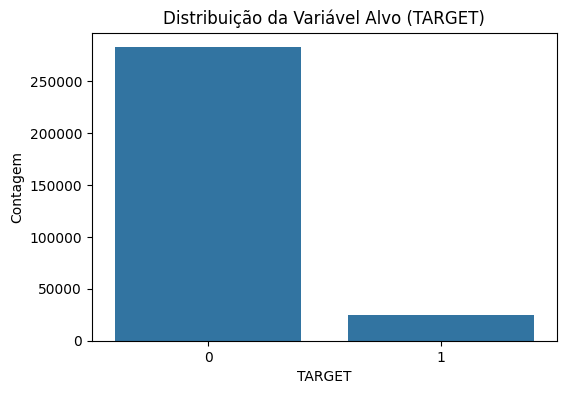

Proporção de créditos aprovados: 8.07%
Proporção de créditos não aprovados: 91.93%


In [60]:
# Gráfico da distribuição da variável TARGET
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=df_final)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.xlabel('TARGET')
plt.ylabel('Contagem')
plt.show()

# Contagem de casos de aprovação e reprovação
count_approved = df_final[df_final['TARGET'] == 1].shape[0]
count_not_approved = df_final[df_final['TARGET'] == 0].shape[0]

# Total de registros
total_records = df_final.shape[0]

# Proporção de aprovação e reprovação
proportion_approved = count_approved / total_records
proportion_not_approved = count_not_approved / total_records

print(f"Proporção de créditos aprovados: {proportion_approved:.2%}")
print(f"Proporção de créditos não aprovados: {proportion_not_approved:.2%}")

In [61]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 116 entries, SK_ID_CURR to QTD_PARCELAS
dtypes: float64(90), int64(15), object(11)
memory usage: 272.2+ MB


In [62]:
df_final.drop(columns=["SK_ID_CURR"], inplace=True)

In [63]:
# # Calcula correlação entre variáveis numéricas e a variável TARGET do df_train_clean_final
# corr = df_final.corr(method='spearman', numeric_only=True)

# # Máscara para o triângulo superior
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Configuração do gráfico
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
# plt.title("Matriz de Correlação com a Variável Alvo (TARGET)")
# plt.show()

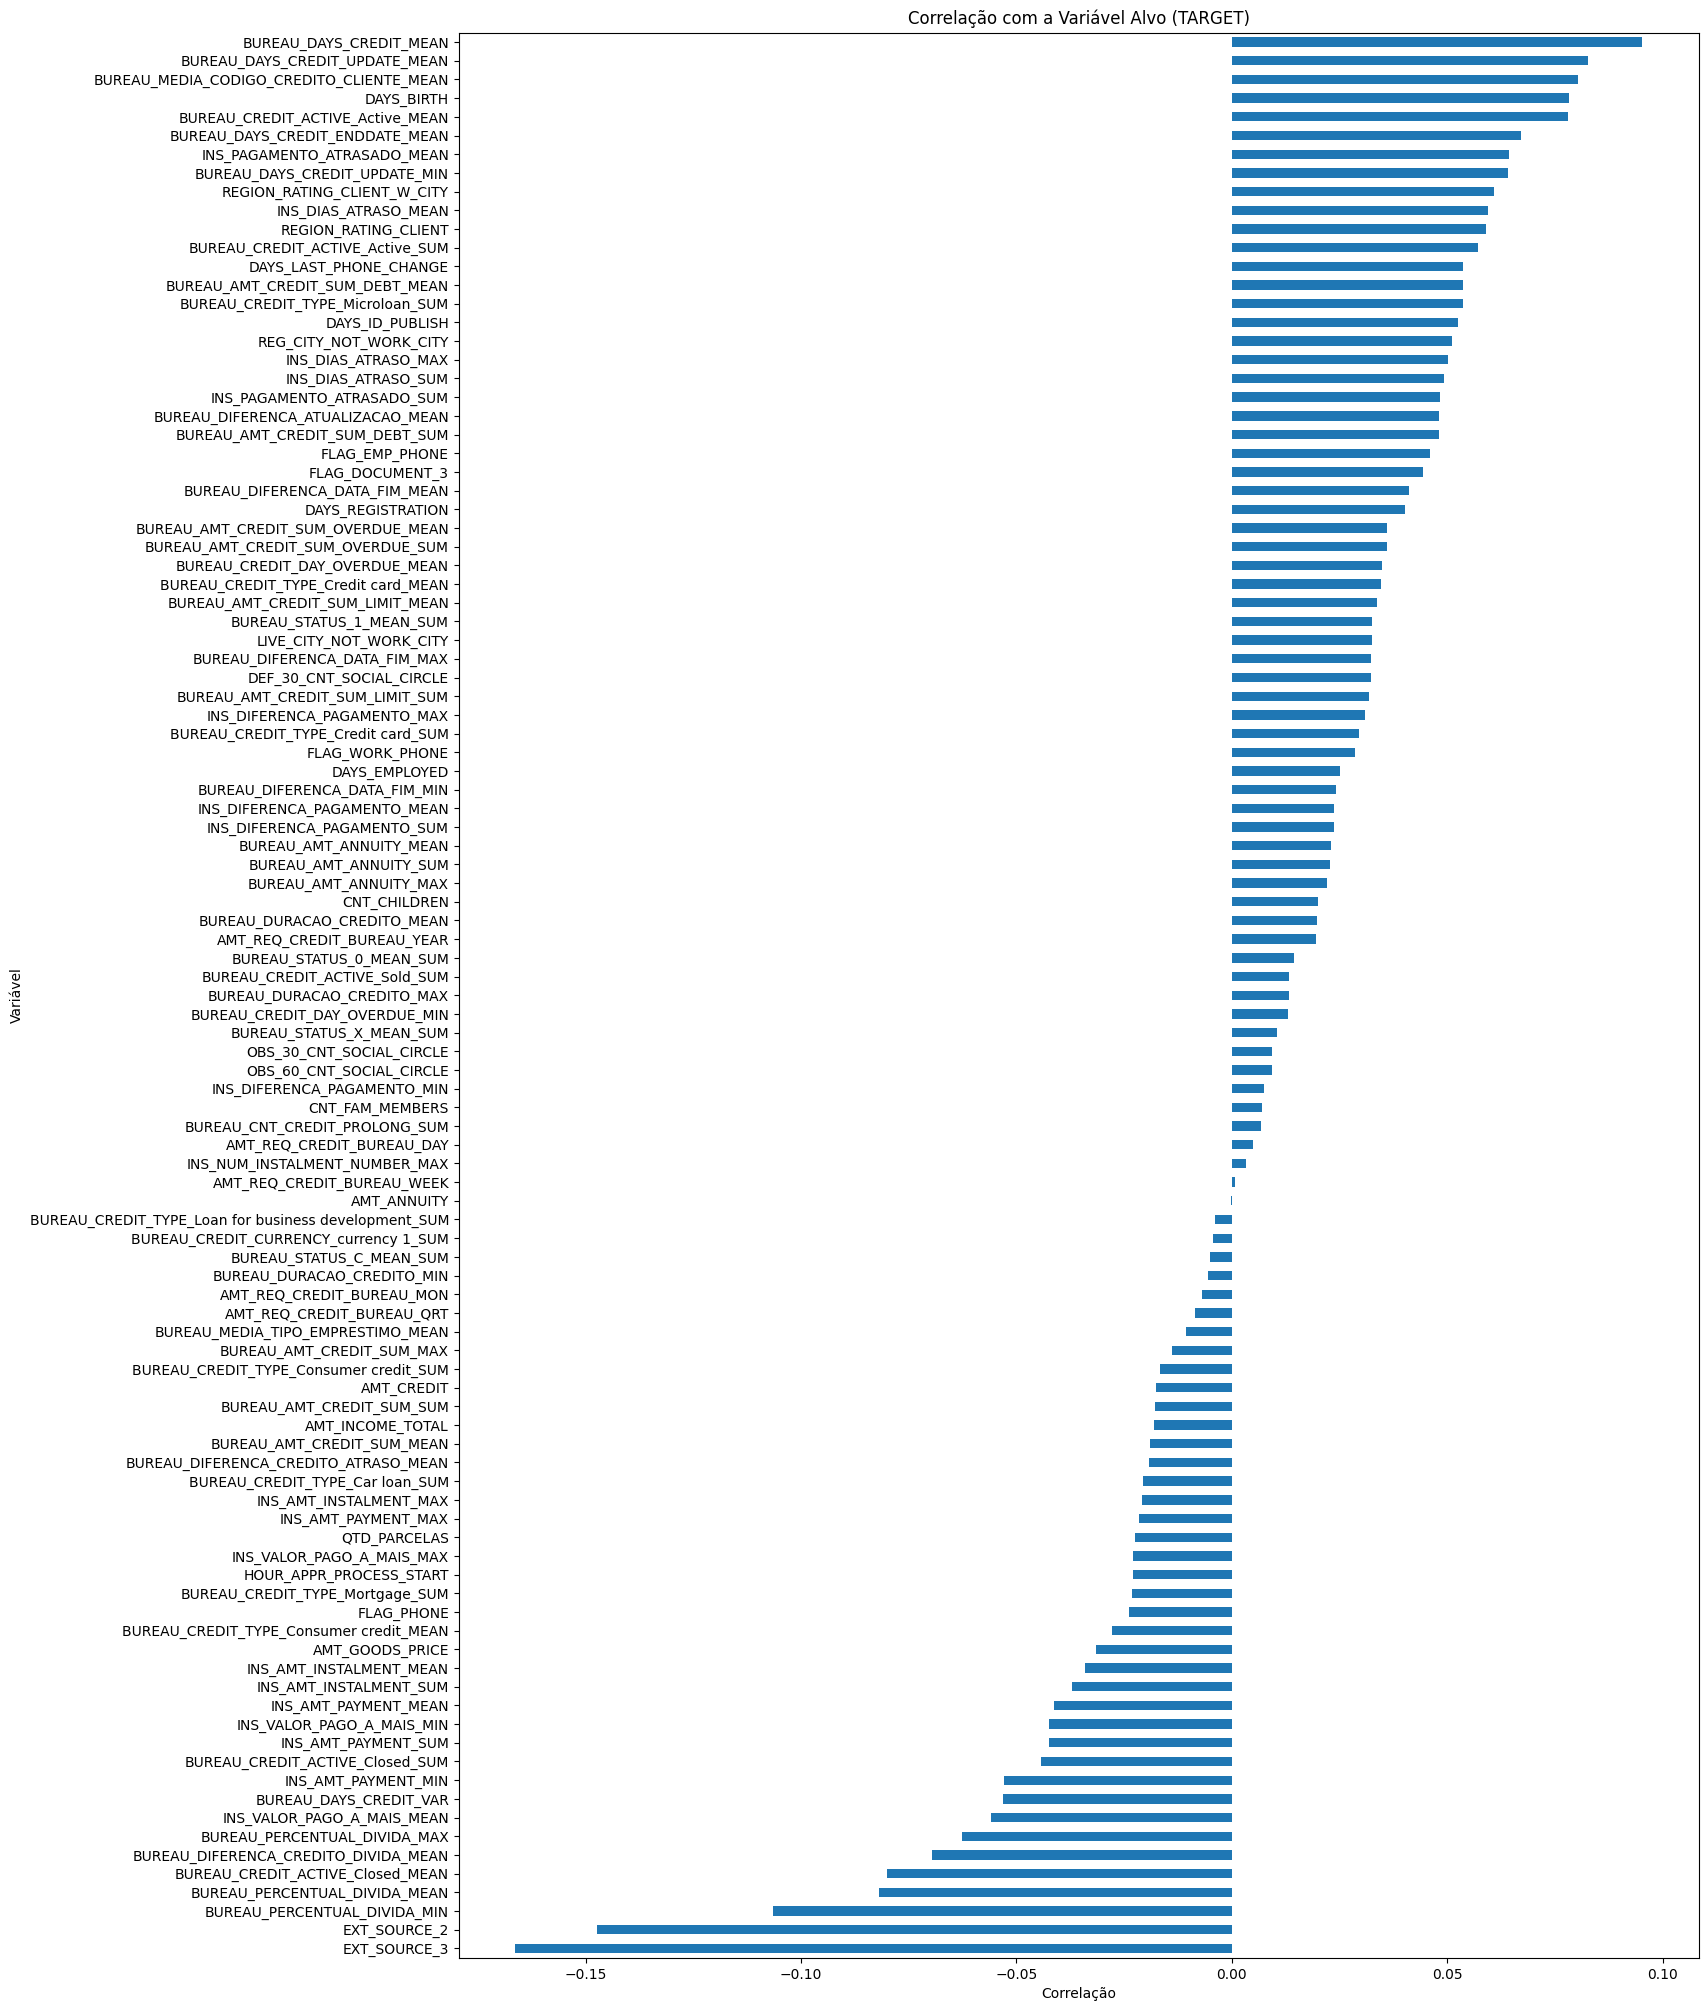

In [64]:
# Correlação entre variáveis numéricas e a variável TARGET
correlations = df_final.corr(method='spearman', numeric_only=True)['TARGET'].sort_values()
plt.figure(figsize=(16, 25))
correlations.drop('TARGET').plot(kind='barh')
plt.title('Correlação com a Variável Alvo (TARGET)')
plt.xlabel('Correlação')
plt.ylabel('Variável')
plt.show()

In [65]:
low_corr_features = correlations[correlations.abs() < 0.025].index
df_final = df_final.drop(columns=low_corr_features)

# Modelagem

In [66]:
df_modelagem = df_final.copy()

In [67]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)  # Substitui caracteres especiais por "_"
    df.columns = df.columns.str.replace(r'\s+', '_', regex=True)  # Remove espaços em branco
    df.columns = df.columns.str.strip('_')  # Remove "_" do começo e do fim dos nomes
    df.columns = df.columns.str.lower()  # Converte para minúsculas para padronização
    return df

df_modelagem = clean_column_names(df_modelagem)

In [68]:
# Identificar colunas binárias
def identify_binary_columns(df):
    """Identifica colunas binárias no dataframe"""
    binary_cols = []
    for col in df.columns:
        unique_values = df[col].dropna().unique()  # Remove NaN antes de contar
        if len(unique_values) == 2:  # Se tiver apenas dois valores distintos
            binary_cols.append(col)
    return binary_cols

# Aplicar a função nos dados de treino
binary_features = identify_binary_columns(df_modelagem)

# Converter colunas binárias de string para 0 e 1
binary_mapping = {
    'Y': 1, 'N': 0,
}

for col in binary_features:
    if df_modelagem[col].dtype == 'object':  # Se for string
        df_modelagem[col] = df_modelagem[col].map(binary_mapping).astype(int)

In [69]:
X, y = df_modelagem.drop(columns='target'), df_modelagem['target']

# Dividindo os dados mantendo o desbalanceamento original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((215257, 69), (92254, 69), 215257, 92254)

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215257 entries, 159703 to 301908
Data columns (total 69 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   code_gender                               215257 non-null  object 
 1   flag_own_car                              215257 non-null  int32  
 2   flag_own_realty                           215257 non-null  int32  
 3   amt_goods_price                           215070 non-null  float64
 4   name_type_suite                           214356 non-null  object 
 5   name_income_type                          215257 non-null  object 
 6   name_education_type                       215257 non-null  object 
 7   name_family_status                        215257 non-null  object 
 8   name_housing_type                         215257 non-null  object 
 9   days_birth                                215257 non-null  int64  
 10  days_employed       

In [71]:
# Identificando as colunas por tipo de dado
cat_features = X_train.select_dtypes(include=['object']).columns
num_features = X_train.select_dtypes(include=['float64', 'int64']).columns
ord_features = ["region_rating_client", "region_rating_client_w_city"]
bin_features = [col for col in binary_features if col != "target"]

num_features = [col for col in num_features if col not in bin_features]

In [ ]:
# Criando as transformações para cada tipo de dado

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),      # Preenchimento de valores ausentes com a média
    ('scaler', MinMaxScaler())                        # Normalização
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),                       # Preenchimento com valor mais frequente
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))     # One-hot encoding
])

ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),                    # Preenchimento com valor mais frequente
    ('ordinal', OrdinalEncoder(handle_unknown='ignore', unknown_value=-1))   # Encoding ordinal
])

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preenchimento de valores ausentes
])

# Criando o fluxo pré-processador com ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('ord', ordinal_transformer, ord_features),
    ('binary', binary_transformer, bin_features)
])

In [73]:
# Criando pipeline para cada modelo (pré-processamento + modelo)
def create_pipeline(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Pré-processamento
        ('model', model)                 # Modelo de Machine Learning
    ])
    return pipeline

In [74]:
# Ajustando pesos das classes para modelos que aceitam class_weight
classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

# Ajustando scale_pos_weight para XGBoost
contagens = np.bincount(y)
scale_pos_weight = contagens[0] / contagens[1]

In [75]:
# Modelos (os 4 cavaleiros do apocalipse)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=int(scale_pos_weight), random_state=42),
    "lightgbm": LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1, n_jobs=-1),
    "CatBoost": CatBoostClassifier(iterations=100, class_weights=class_weight_dict, random_state=42, verbose=0)
}


Avaliando Modelo: Random Forest
  - Accuracy: 0.9194
  - Precision: 0.7273
  - Recall: 0.0032
  - F1 Score: 0.0064


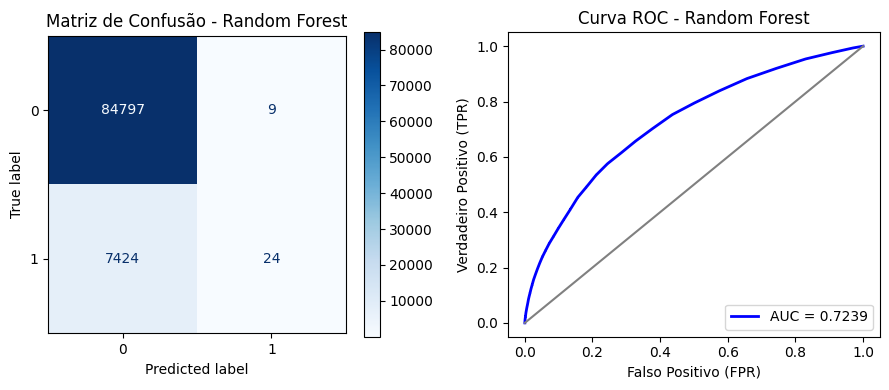


Avaliando Modelo: XGBoost
  - Accuracy: 0.7532
  - Precision: 0.1825
  - Recall: 0.5914
  - F1 Score: 0.2790


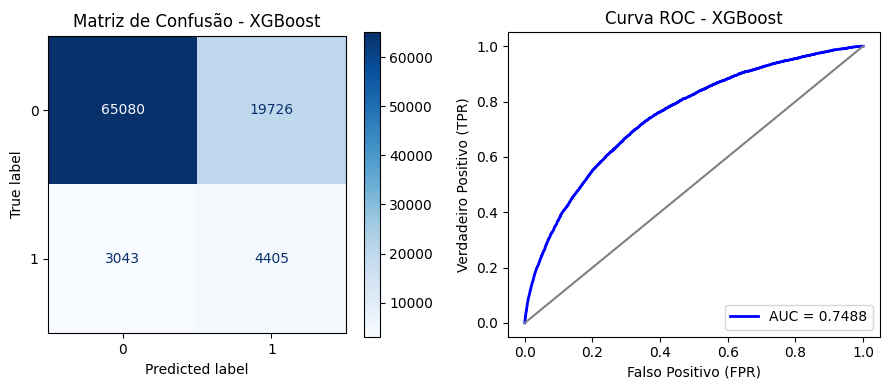


Avaliando Modelo: lightgbm
  - Accuracy: 0.7143
  - Precision: 0.1744
  - Recall: 0.6800
  - F1 Score: 0.2776


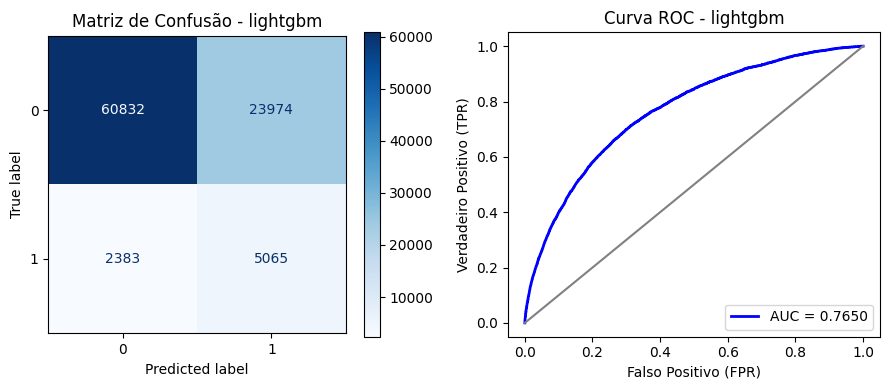


Avaliando Modelo: CatBoost
  - Accuracy: 0.7203
  - Precision: 0.1721
  - Recall: 0.6466
  - F1 Score: 0.2718


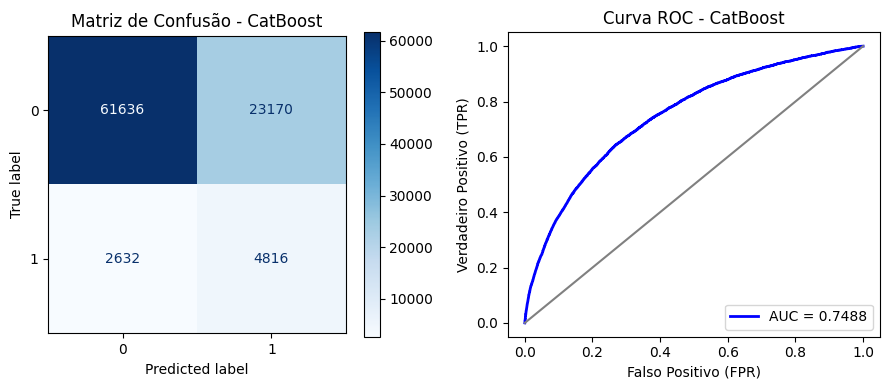

In [77]:
# Treinar e avaliar os modelos
for name, model in models.items():
    print(f"\nAvaliando Modelo: {name}")
    
    # Criar pipeline
    pipeline = create_pipeline(model)

    # Treinar o modelo
    pipeline.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

    # Métricas de avaliação
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Precision: {prec:.4f}")
    print(f"  - Recall: {rec:.4f}")
    print(f"  - F1 Score: {f1:.4f}")
    
    # Criar figura com 2 subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    
    # Plotar Matriz de Confusão no primeiro subplot
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], cmap='Blues', values_format='d')
    axs[0].set_title(f"Matriz de Confusão - {name}")
    
    # Plotar Curva ROC AUC no segundo subplot
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
    axs[1].plot([0, 1], [0, 1], color='gray')
    axs[1].set_xlabel("Falso Positivo (FPR)")
    axs[1].set_ylabel("Verdadeiro Positivo (TPR)")
    axs[1].set_title(f"Curva ROC - {name}")
    axs[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

## Tuning do Modelo - lightgbm

In [78]:
# Aplicando o pipeline nos dados antes de passar para o Optuna
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [79]:
feature_names = preprocessor.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

X_train_transformed_df.head()

,num__amt_goods_price,num__days_birth,num__days_employed,num__days_registration,num__days_id_publish,num__region_rating_client,num__region_rating_client_w_city,num__ext_source_2,num__ext_source_3,num__def_30_cnt_social_circle,num__days_last_phone_change,num__bureau_amt_credit_sum_debt_mean,num__bureau_amt_credit_sum_debt_sum,num__bureau_amt_credit_sum_overdue_mean,num__bureau_amt_credit_sum_overdue_sum,num__bureau_days_credit_mean,num__bureau_days_credit_var,num__bureau_days_credit_update_mean,num__bureau_days_credit_update_min,num__bureau_credit_day_overdue_mean,num__bureau_days_credit_enddate_mean,num__bureau_amt_credit_sum_limit_mean,num__bureau_amt_credit_sum_limit_sum,num__bureau_diferenca_data_fim_mean,num__bureau_diferenca_data_fim_max,num__bureau_diferenca_atualizacao_mean,num__bureau_percentual_divida_mean,num__bureau_percentual_divida_max,num__bureau_percentual_divida_min,num__bureau_diferenca_credito_divida_mean,num__bureau_media_codigo_credito_cliente_mean,num__bureau_credit_active_active_mean,num__bureau_credit_active_active_sum,num__bureau_credit_active_closed_mean,num__bureau_credit_active_closed_sum,num__bureau_credit_type_consumer_credit_mean,num__bureau_credit_type_credit_card_mean,num__bureau_credit_type_credit_card_sum,num__bureau_credit_type_microloan_sum,num__bureau_status_1_mean_sum,num__ins_pagamento_atrasado_mean,num__ins_pagamento_atrasado_sum,num__ins_amt_payment_min,num__ins_amt_payment_mean,num__ins_amt_payment_sum,num__ins_amt_instalment_mean,num__ins_amt_instalment_sum,num__ins_diferenca_pagamento_max,num__ins_valor_pago_a_mais_mean,num__ins_valor_pago_a_mais_min,num__ins_dias_atraso_max,num__ins_dias_atraso_mean,num__ins_dias_atraso_sum,cat__code_gender_F,cat__code_gender_M,cat__code_gender_XNA,cat__name_type_suite_Children,cat__name_type_suite_Family,cat__name_type_suite_Group of people,cat__name_type_suite_Other_A,cat__name_type_suite_Other_B,"cat__name_type_suite_Spouse, partner",cat__name_type_suite_Unaccompanied,cat__name_income_type_Businessman,cat__name_income_type_Commercial associate,cat__name_income_type_Maternity leave,cat__name_income_type_Pensioner,cat__name_income_type_State servant,cat__name_income_type_Student,cat__name_income_type_Unemployed,cat__name_income_type_Working,cat__name_education_type_Academic degree,cat__name_education_type_Higher education,cat__name_education_type_Incomplete higher,cat__name_education_type_Lower secondary,cat__name_education_type_Secondary / secondary special,cat__name_family_status_Civil marriage,cat__name_family_status_Married,cat__name_family_status_Separated,cat__name_family_status_Single / not married,cat__name_family_status_Unknown,cat__name_family_status_Widow,cat__name_housing_type_Co-op apartment,cat__name_housing_type_House / apartment,cat__name_housing_type_Municipal apartment,cat__name_housing_type_Office apartment,cat__name_housing_type_Rented apartment,cat__name_housing_type_With parents,cat__occupation_type_Accountants,cat__occupation_type_Cleaning staff,cat__occupation_type_Cooking staff,cat__occupation_type_Core staff,cat__occupation_type_Drivers,cat__occupation_type_HR staff,cat__occupation_type_High skill tech staff,cat__occupation_type_IT staff,cat__occupation_type_Laborers,cat__occupation_type_Low-skill Laborers,cat__occupation_type_Managers,cat__occupation_type_Medicine staff,cat__occupation_type_Private service staff,cat__occupation_type_Realty agents,cat__occupation_type_Sales staff,cat__occupation_type_Secretaries,cat__occupation_type_Security staff,cat__occupation_type_Waiters/barmen staff,cat__weekday_appr_process_start_FRIDAY,cat__weekday_appr_process_start_MONDAY,cat__weekday_appr_process_start_SATURDAY,cat__weekday_appr_process_start_SUNDAY,cat__weekday_appr_process_start_THURSDAY,cat__weekday_appr_process_start_TUESDAY,cat__weekday_appr_process_start_WEDNESDAY,cat__organization_type_Advertising,cat__organization_type_Agriculture,cat__organization_type_Bank,cat__organization_type_Business Entity Type 1,cat__organization

In [80]:
X_train_transformed_df.shape

(215257, 180)

In [81]:
# Função objetivo para o Optuna (Maximizar F1-score)
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),          # Número de árvores no modelo (100 a 1000, com passo de 50)
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),     # Taxa de aprendizado (0.01 a 0.3)
        "max_depth": trial.suggest_int("max_depth", 3, 15),                             # Profundidade máxima da árvore (3 a 15)
        "num_leaves": trial.suggest_int("num_leaves", 20, 200, step=10),                # Número de folhas da árvore (20 a 200)
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100, step=5),    # Mínimo de amostras por folha (5 a 100)
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),                        # Percentual de amostras usadas por árvore (0.5 a 1.0)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),          # Percentual de colunas usadas por árvore (0.5 a 1.0)
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),            # Regularização L1 (1e-8 a 10.0)
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)           # Regularização L2 (1e-8 a 10.0)
    }

    model = LGBMClassifier(**params, random_state=42, class_weight='balanced', n_jobs=-1)   # Criando o modelo LightGBM
    model.fit(X_train_transformed, y_train)                                                 # Treinando o modelo
    y_pred = model.predict(X_test_transformed)                                              # Fazendo previsões
    f1 = f1_score(y_test, y_pred)                                                           # Calculando o F1-score (quanto maior, melhor)

    return f1

In [82]:
# Criando o estudo do Optuna para maximizar o F1-score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-03-09 17:23:28,620] A new study created in memory with name: no-name-9b387081-666f-43f1-a4ba-374568d05063


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-09 17:23:32,332] Trial 0 finished with value: 0.29019445593711213 and parameters: {'n_estimators': 350, 'learning_rate': 0.22471185003936378, 'max_depth': 7, 'num_leaves': 130, 'min_child_samples': 100, 'subsample': 0.7918604511650313, 'colsample_bytree': 0.965941992583291, 'reg_alpha': 2.1566416853179966e-06, 'reg_lambda': 1.2574433180920939}. Best is trial 0 with value: 0.29019445593711213.
[I 2025-03-09 17:23:39,261] Trial 1 finished with value: 0.2797090627506292 and parameters: {'n_estimators': 500, 'learning_rate': 0.011989674661322516, 'max_depth': 14, 'num_leaves': 60, 'min_child_samples': 30, 'subsample': 0.5104734667957116, 'colsample_bytree': 0.8018051521753007, 'reg_alpha': 0.04503852983553535, 'reg_lambda': 3.691966932186285e-05}. Best is trial 0 with value: 0.29019445593711213.
[I 2025-03-09 17:23:48,722] Trial 2 finished with value: 0.26045355700528117 and parameters: {'n_estimators': 900, 'learning_rate': 0.14434670123026805, 'max_depth': 11, 'num_leaves': 80

In [83]:
# Exibir melhores hiperparâmetros encontrados
print("Melhores parâmetros encontrados:", study.best_params)

Melhores parâmetros encontrados: {'n_estimators': 800, 'learning_rate': 0.03505773850274863, 'max_depth': 13, 'num_leaves': 170, 'min_child_samples': 50, 'subsample': 0.6345458717481246, 'colsample_bytree': 0.5108998531317953, 'reg_alpha': 2.2560515410966855, 'reg_lambda': 0.15651151420523085}


In [84]:
best_params = study.best_params # Pegando os melhores hiperparâmetros encontrados

# Criando o modelo otimizado
best_model = LGBMClassifier(**best_params, random_state=42, class_weight='balanced', n_jobs=-1)
best_model.fit(X_train_transformed, y_train)

# Fazendo previsões no conjunto de teste
y_pred = best_model.predict(X_test_transformed)
y_prob = best_model.predict_proba(X_test_transformed)[:, 1]  # Probabilidade da classe positiva

In [85]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nResultados do Modelo Ajustado")
print(f"  - Accuracy: {acc:.4f}")
print(f"  - Precision: {prec:.4f}")
print(f"  - Recall: {rec:.4f}")
print(f"  - F1 Score: {f1:.4f}")


Resultados do Modelo Ajustado
  - Accuracy: 0.8340
  - Precision: 0.2333
  - Recall: 0.4621
  - F1 Score: 0.3101


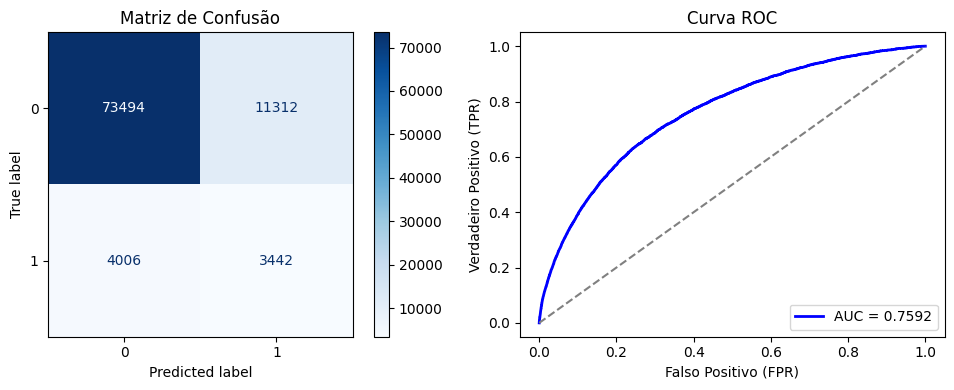

In [86]:
# Criar figura com 2 subplots para Matriz de Confusão e Curva ROC
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs[0], cmap='Blues', values_format='d')
axs[0].set_title("Matriz de Confusão")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
axs[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1].set_xlabel("Falso Positivo (FPR)")
axs[1].set_ylabel("Verdadeiro Positivo (TPR)")
axs[1].set_title("Curva ROC")
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## Calibrando Modelo

> 🔥 O que é Calibração de Probabilidades?

Calibração significa **ajustar as probabilidades do modelo para que reflitam a realidade**.

Um modelo de machine learning de classificação **retorna probabilidades** ao prever um resultado. Por exemplo:

➡️ **Sem calibração:**  
O modelo prevê que **um cliente tem 90% de chance de não pagar um empréstimo**, mas na prática, apenas **60% dos clientes com essa previsão realmente não pagam**.  
Ou seja, o modelo **superestimou a confiança** da previsão.

➡️ **Com calibração:**  
Após a calibração, se o modelo prevê **90% de chance**, então **realmente 90% das pessoas nessa faixa não pagam**.

**A calibração corrige esse erro e torna as previsões mais confiáveis!** ✅

---

> 🎯 Exemplo Simples: Apostando no Clima

Imagine que você tem um **modelo que prevê a chance de chover amanhã**:

- Ele diz que **vai chover com 80% de probabilidade**.
- Mas, olhando **100 dias com essa previsão**, só choveu **60 vezes**.

Isso significa que o modelo **superestima a probabilidade** de chuva.  
A calibração ajustaria esse valor de **80% para 60%**, tornando-o **mais realista**.

---

> 🔎 Como Funciona a Calibração?

A calibração compara **as previsões do modelo** com **o que realmente aconteceu** e ajusta as probabilidades.

> **1️⃣ Sem Calibração (Modelo mal ajustado)**

| Probabilidade Prevista | Frequência Real |
|------------------------|----------------|
| 90% de chance de não pagar | 60% realmente não pagaram |
| 50% de chance de não pagar | 50% realmente não pagaram |
| 20% de chance de não pagar | 30% realmente não pagaram |

🔴 **O modelo está confiante demais!** Ele prevê **90%**, mas só **60% realmente não pagam**.

---

> **2️⃣ Com Calibração (Modelo Ajustado)**

Após a calibração, os valores ficam mais realistas:

| Probabilidade Ajustada | Frequência Real |
|------------------------|----------------|
| 60% de chance de não pagar | 60% realmente não pagaram |
| 50% de chance de não pagar | 50% realmente não pagaram |
| 30% de chance de não pagar | 30% realmente não pagaram |

✅ **Agora as previsões refletem melhor a realidade**.

---

> ⚙️ Como Calibramos um Modelo no `sklearn`?

Podemos usar `CalibratedClassifierCV` no **scikit-learn**, que ajusta as probabilidades do modelo automaticamente.

> **Métodos de Calibração**

1. **Platt Scaling (`method="sigmoid"`)**  
   - Usa uma **função sigmoide** para ajustar as probabilidades.  
   - Funciona bem quando o modelo já tem **boa separação entre classes**.  
   - Melhor para **dados menos desbalanceados**.  

2. **Isotonic Regression (`method="isotonic"`)**  
   - Usa **regressão isotônica**, que ajusta as probabilidades sem forçar uma forma específica.  
   - Funciona melhor quando as previsões estão **muito erradas**.  
   - Precisa de **mais dados de calibração** para funcionar bem.

---

🎯 Quando usar a calibração?  
✅ Quando as probabilidades previstas pelo modelo não refletem bem a realidade.  
✅ Quando precisamos interpretar diretamente as probabilidades (exemplo: aprovar um empréstimo se a chance de inadimplência for maior que 70%).  
✅ Quando usamos modelos como Random Forest, Gradient Boosting (LightGBM, XGBoost), que podem ser mal calibrados.  

In [87]:
# Pegando os melhores hiperparâmetros encontrados no Optuna
best_params = study.best_params

# Criando e treinando o modelo final sem calibração
best_model = LGBMClassifier(**best_params, random_state=42, class_weight='balanced', n_jobs=-1)
best_model.fit(X_train_transformed, y_train)

# Criando um modelo calibrado (Platt Scaling ou Isotonic)
calibrated_model = CalibratedClassifierCV(best_model, method="sigmoid", cv=5, n_jobs=-1)

# Treinar o modelo calibrado
calibrated_model.fit(X_train_transformed, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(class_weight='balanced',
                                                colsample_bytree=0.5108998531317953,
                                                learning_rate=0.03505773850274863,
                                                max_depth=13,
                                                min_child_samples=50,
                                                n_estimators=800, n_jobs=-1,
                                                num_leaves=170, random_state=42,
                                                reg_alpha=2.2560515410966855,
                                                reg_lambda=0.15651151420523085,
                                                subsample=0.6345458717481246),
                       n_jobs=-1)

In [88]:
# Previsões antes e depois da calibração
y_pred_before = best_model.predict(X_test_transformed)
y_prob_before = best_model.predict_proba(X_test_transformed)[:, 1]

y_pred_after = calibrated_model.predict(X_test_transformed)
y_prob_after = calibrated_model.predict_proba(X_test_transformed)[:, 1]

In [89]:
# Calculando métricas antes e depois da calibração

metrics_before = {
    "AUC-ROC": roc_auc_score(y_test, y_prob_before),
    "Accuracy": accuracy_score(y_test, y_pred_before),
    "Precision": precision_score(y_test, y_pred_before, zero_division=0),
    "Recall": recall_score(y_test, y_pred_before, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_before, zero_division=0)
}

metrics_after = {
    "AUC-ROC": roc_auc_score(y_test, y_prob_after),
    "Accuracy": accuracy_score(y_test, y_pred_after),
    "Precision": precision_score(y_test, y_pred_after, zero_division=0),
    "Recall": recall_score(y_test, y_pred_after, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_after, zero_division=0)
}

# Comparação das métricas antes e depois
print("\nComparação das Métricas Antes e Depois da Calibração")
for metric in metrics_before.keys():
    print(f"{metric}: Antes = {metrics_before[metric]:.4f} | Depois = {metrics_after[metric]:.4f}")


Comparação das Métricas Antes e Depois da Calibração
AUC-ROC: Antes = 0.7592 | Depois = 0.7632
Accuracy: Antes = 0.8340 | Depois = 0.9194
Precision: Antes = 0.2333 | Depois = 0.7895
Recall: Antes = 0.4621 | Depois = 0.0020
F1 Score: Antes = 0.3101 | Depois = 0.0040


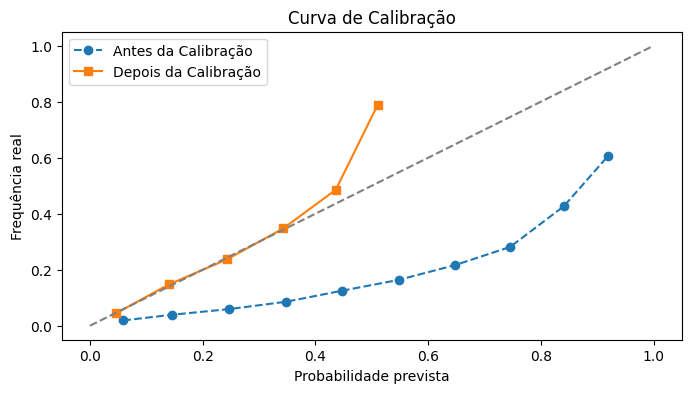

In [90]:
# Criando a Curva de Calibração
plt.figure(figsize=(8, 4))
prob_true_before, prob_pred_before = calibration_curve(y_test, y_prob_before, n_bins=10)
prob_true_after, prob_pred_after = calibration_curve(y_test, y_prob_after, n_bins=10)

# Plotando
plt.plot(prob_pred_before, prob_true_before, marker="o", label="Antes da Calibração", linestyle="dashed")
plt.plot(prob_pred_after, prob_true_after, marker="s", label="Depois da Calibração", linestyle="solid")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha de referência perfeita
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Curva de Calibração")
plt.legend()
plt.show()

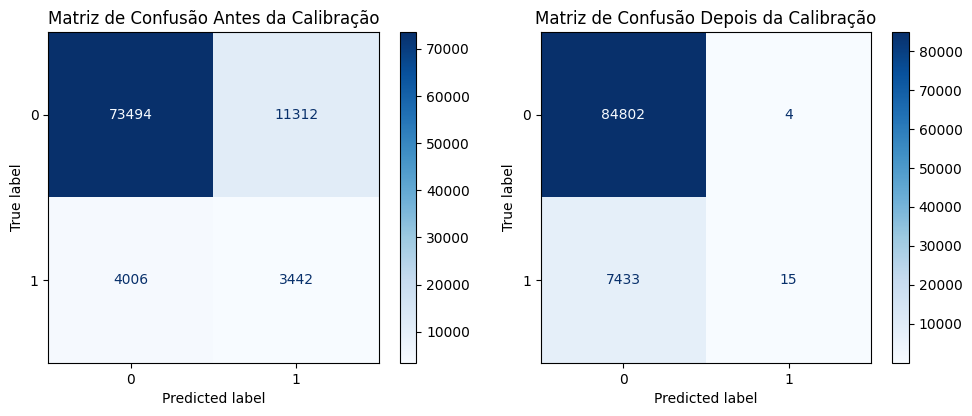

In [91]:
# Criando a Matriz de Confusão antes e depois
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de Confusão antes da calibração
cm_before = confusion_matrix(y_test, y_pred_before)
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot(ax=axs[0], cmap='Blues', values_format='d')
axs[0].set_title("Matriz de Confusão Antes da Calibração")

# Matriz de Confusão depois da calibração
cm_after = confusion_matrix(y_test, y_pred_after)
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot(ax=axs[1], cmap='Blues', values_format='d')
axs[1].set_title("Matriz de Confusão Depois da Calibração")

plt.tight_layout()
plt.show()

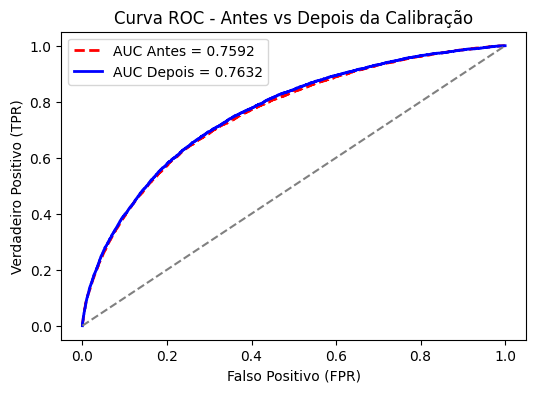

In [92]:
# Comparação da Curva ROC antes e depois
fpr_before, tpr_before, _ = roc_curve(y_test, y_prob_before)
fpr_after, tpr_after, _ = roc_curve(y_test, y_prob_after)

plt.figure(figsize=(6, 4))
plt.plot(fpr_before, tpr_before, color='red', lw=2, linestyle="dashed", label=f'AUC Antes = {metrics_before["AUC-ROC"]:.4f}')
plt.plot(fpr_after, tpr_after, color='blue', lw=2, label=f'AUC Depois = {metrics_after["AUC-ROC"]:.4f}')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha de referência
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curva ROC - Antes vs Depois da Calibração")
plt.legend()
plt.show()

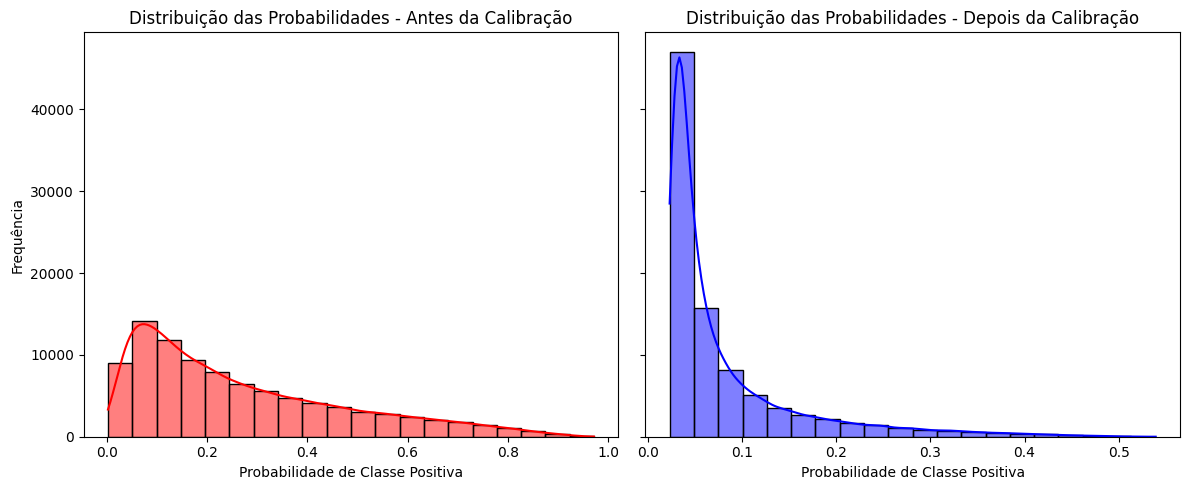

In [93]:
# Criando a figura com 2 subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plotando o histograma das probabilidades antes da calibração
sns.histplot(y_prob_before, bins=20, kde=True, color='red', ax=axs[0])
axs[0].set_title("Distribuição das Probabilidades - Antes da Calibração")
axs[0].set_xlabel("Probabilidade de Classe Positiva")
axs[0].set_ylabel("Frequência")

# Plotando o histograma das probabilidades depois da calibração
sns.histplot(y_prob_after, bins=20, kde=True, color='blue', ax=axs[1])
axs[1].set_title("Distribuição das Probabilidades - Depois da Calibração")
axs[1].set_xlabel("Probabilidade de Classe Positiva")

plt.tight_layout()
plt.show()


Métricas para Limiar = 0.5
Accuracy: 0.9194
Precision: 0.7895
Recall: 0.0020
F1 Score: 0.0040

Matriz de Confusão para Limiar = 0.5


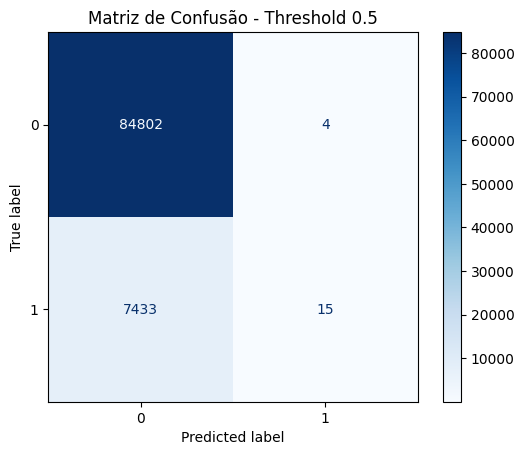


Métricas para Limiar = 0.4
Accuracy: 0.9192
Precision: 0.4932
Recall: 0.0490
F1 Score: 0.0892

Matriz de Confusão para Limiar = 0.4


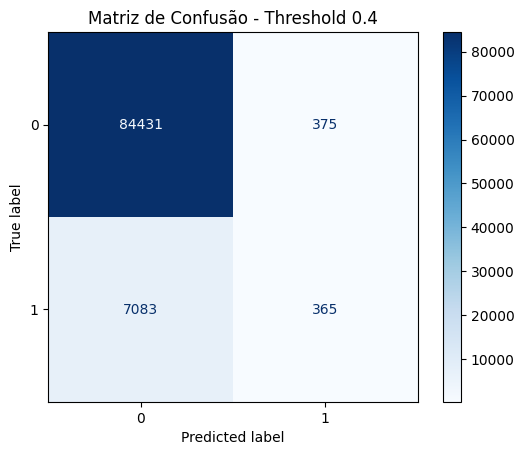


Métricas para Limiar = 0.3
Accuracy: 0.9117
Precision: 0.3837
Recall: 0.1537
F1 Score: 0.2195

Matriz de Confusão para Limiar = 0.3


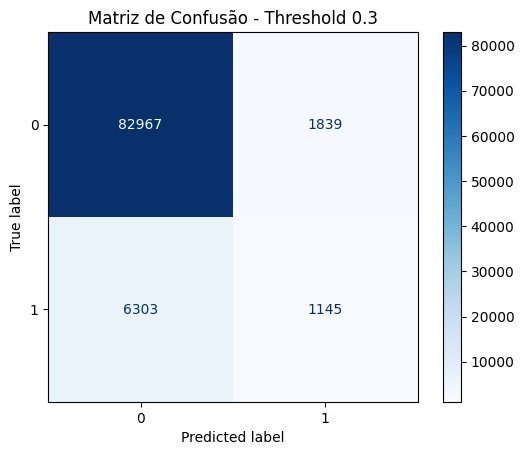


Métricas para Limiar = 0.2
Accuracy: 0.8827
Precision: 0.2911
Recall: 0.3157
F1 Score: 0.3029

Matriz de Confusão para Limiar = 0.2


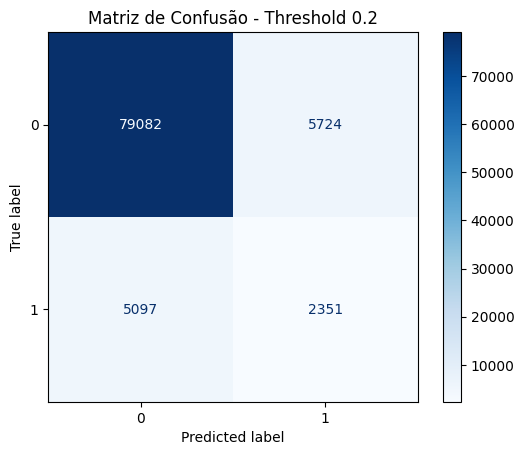

In [94]:
# Testar diferentes limiares
for threshold in [0.5, 0.4, 0.3, 0.2]:
    y_pred_custom = (y_prob_after >= threshold).astype(int)

    # Calcular métricas para o limiar
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred_custom),
        "Precision": precision_score(y_test, y_pred_custom, zero_division=0),
        "Recall": recall_score(y_test, y_pred_custom, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred_custom, zero_division=0)
    }

    # Exibir métricas
    print(f"\nMétricas para Limiar = {threshold}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Exibir a Matriz de Confusão
    print(f"\nMatriz de Confusão para Limiar = {threshold}")
    cm = confusion_matrix(y_test, y_pred_custom)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Matriz de Confusão - Threshold {threshold}")
    plt.show()

## Teste Final

In [95]:
df_final_test = pd.read_csv(Path("data", "01_raw", "application_test.csv"))

In [96]:
final_test_merged = df_final_test.merge(bureau_balance_final, on='SK_ID_CURR', how='left')
final_test_merged = final_test_merged.merge(installments_clean, on='SK_ID_CURR', how='left')

In [97]:
final_test_merged.shape

(48744, 243)

In [98]:
final_test_merged = clean_column_names(final_test_merged)

for col in bin_features:
    if final_test_merged[col].dtype == 'object':  # Se for string
        final_test_merged[col] = final_test_merged[col].map(binary_mapping).astype(int)

final_test_merged.head()

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,...,bureau_duracao_credito_mean,bureau_duracao_credito_max,bureau_duracao_credito_min,bureau_diferenca_data_fim_mean,bureau_diferenca_data_fim_max,bureau_diferenca_data_fim_min,bureau_diferenca_atualizacao_mean,bureau_percentual_divida_mean,bureau_percentual_divida_max,bureau_percentual_divida_min,bureau_diferenca_credito_divida_mean,bureau_razao_credito_anuidade_mean,bureau_razao_credito_anuidade_max,bureau_razao_divida_anuidade_mean,bureau_diferenca_credito_atraso_mean,bureau_media_tipo_emprestimo_mean,bureau_media_codigo_credito_cliente_mean,bureau_credit_active_active_mean,bureau_credit_active_active_sum,bureau_credit_active_bad_debt_mean,bureau_credit_active_bad_debt_sum,bureau_credit_active_closed_mean,bureau_credit_active_closed_sum,bureau_credit_active_sold_mean,bureau_credit_active_sold_sum,bureau_credit_currency_currency_1_mean,bureau_credit_currency_currency_1_sum,bureau_credit_currency_currency_2_mean,bureau_credit_currency_currency_2_sum,bureau_credit_currency_currency_3_mean,bureau_credit_currency_currency_3_sum,bureau_credit_currency_currency_4_mean,bureau_credit_currency_currency_4_sum,bureau_credit_type_another_type_of_loan_mean,bureau_credit_type_another_type_of_loan_sum,bureau_credit_type_car_loan_mean,bureau_credit_type_car_loan_sum,bureau_credit_type_cash_loan__non_earmarked__mean,bureau_credit_type_cash_loan__non_earmarked__sum,bureau_credit_type_consumer_credit_mean,bureau_credit_type_consumer_credit_sum,bureau_credit_type_credit_card_mean,bureau_credit_type_credit_card_sum,bureau_credit_type_interbank_credit_mean,bureau_credit_type_interbank_credit_sum,bureau_credit_type_loan_for_business_development_mean,bureau_credit_type_loan_for_business_development_sum,bureau_credit_type_loan_for_purchase_of_shares__margin_lending__mean,bureau_credit_type_loan_for_purchase_of_shares__margin_lending__sum,bureau_credit_type_loan_for_the_purchase_of_equipment_mean,bureau_credit_type_loan_for_the_purchase_of_equipment_sum,bureau_credit_type_loan_for_working_capital_replenishment_mean,bureau_credit_type_loan_for_working_capital_replenishment_sum,bureau_credit_type_microloan_mean,bureau_credit_type_microloan_sum,bureau_credit_type_mobile_operator_loan_mean,bureau_credit_t

In [99]:
X_final_test_transformed = preprocessor.transform(final_test_merged)

In [100]:
feature_names = preprocessor.get_feature_names_out()
X_final_test_transformed_df = pd.DataFrame(X_final_test_transformed, columns=feature_names)

X_final_test_transformed_df.head()

,num__amt_goods_price,num__days_birth,num__days_employed,num__days_registration,num__days_id_publish,num__region_rating_client,num__region_rating_client_w_city,num__ext_source_2,num__ext_source_3,num__def_30_cnt_social_circle,num__days_last_phone_change,num__bureau_amt_credit_sum_debt_mean,num__bureau_amt_credit_sum_debt_sum,num__bureau_amt_credit_sum_overdue_mean,num__bureau_amt_credit_sum_overdue_sum,num__bureau_days_credit_mean,num__bureau_days_credit_var,num__bureau_days_credit_update_mean,num__bureau_days_credit_update_min,num__bureau_credit_day_overdue_mean,num__bureau_days_credit_enddate_mean,num__bureau_amt_credit_sum_limit_mean,num__bureau_amt_credit_sum_limit_sum,num__bureau_diferenca_data_fim_mean,num__bureau_diferenca_data_fim_max,num__bureau_diferenca_atualizacao_mean,num__bureau_percentual_divida_mean,num__bureau_percentual_divida_max,num__bureau_percentual_divida_min,num__bureau_diferenca_credito_divida_mean,num__bureau_media_codigo_credito_cliente_mean,num__bureau_credit_active_active_mean,num__bureau_credit_active_active_sum,num__bureau_credit_active_closed_mean,num__bureau_credit_active_closed_sum,num__bureau_credit_type_consumer_credit_mean,num__bureau_credit_type_credit_card_mean,num__bureau_credit_type_credit_card_sum,num__bureau_credit_type_microloan_sum,num__bureau_status_1_mean_sum,num__ins_pagamento_atrasado_mean,num__ins_pagamento_atrasado_sum,num__ins_amt_payment_min,num__ins_amt_payment_mean,num__ins_amt_payment_sum,num__ins_amt_instalment_mean,num__ins_amt_instalment_sum,num__ins_diferenca_pagamento_max,num__ins_valor_pago_a_mais_mean,num__ins_valor_pago_a_mais_min,num__ins_dias_atraso_max,num__ins_dias_atraso_mean,num__ins_dias_atraso_sum,cat__code_gender_F,cat__code_gender_M,cat__code_gender_XNA,cat__name_type_suite_Children,cat__name_type_suite_Family,cat__name_type_suite_Group of people,cat__name_type_suite_Other_A,cat__name_type_suite_Other_B,"cat__name_type_suite_Spouse, partner",cat__name_type_suite_Unaccompanied,cat__name_income_type_Businessman,cat__name_income_type_Commercial associate,cat__name_income_type_Maternity leave,cat__name_income_type_Pensioner,cat__name_income_type_State servant,cat__name_income_type_Student,cat__name_income_type_Unemployed,cat__name_income_type_Working,cat__name_education_type_Academic degree,cat__name_education_type_Higher education,cat__name_education_type_Incomplete higher,cat__name_education_type_Lower secondary,cat__name_education_type_Secondary / secondary special,cat__name_family_status_Civil marriage,cat__name_family_status_Married,cat__name_family_status_Separated,cat__name_family_status_Single / not married,cat__name_family_status_Unknown,cat__name_family_status_Widow,cat__name_housing_type_Co-op apartment,cat__name_housing_type_House / apartment,cat__name_housing_type_Municipal apartment,cat__name_housing_type_Office apartment,cat__name_housing_type_Rented apartment,cat__name_housing_type_With parents,cat__occupation_type_Accountants,cat__occupation_type_Cleaning staff,cat__occupation_type_Cooking staff,cat__occupation_type_Core staff,cat__occupation_type_Drivers,cat__occupation_type_HR staff,cat__occupation_type_High skill tech staff,cat__occupation_type_IT staff,cat__occupation_type_Laborers,cat__occupation_type_Low-skill Laborers,cat__occupation_type_Managers,cat__occupation_type_Medicine staff,cat__occupation_type_Private service staff,cat__occupation_type_Realty agents,cat__occupation_type_Sales staff,cat__occupation_type_Secretaries,cat__occupation_type_Security staff,cat__occupation_type_Waiters/barmen staff,cat__weekday_appr_process_start_FRIDAY,cat__weekday_appr_process_start_MONDAY,cat__weekday_appr_process_start_SATURDAY,cat__weekday_appr_process_start_SUNDAY,cat__weekday_appr_process_start_THURSDAY,cat__weekday_appr_process_start_TUESDAY,cat__weekday_appr_process_start_WEDNESDAY,cat__organization_type_Advertising,cat__organization_type_Agriculture,cat__organization_type_Bank,cat__organization_type_Business Entity Type 1,cat__organization

In [101]:
X_final_test_transformed_df.shape

(48744, 180)

In [102]:
# Fazendo previsões no conjunto final de teste
y_pred_final_test = best_model.predict(X_final_test_transformed)
y_prob_final_test = best_model.predict_proba(X_final_test_transformed)[:, 1]

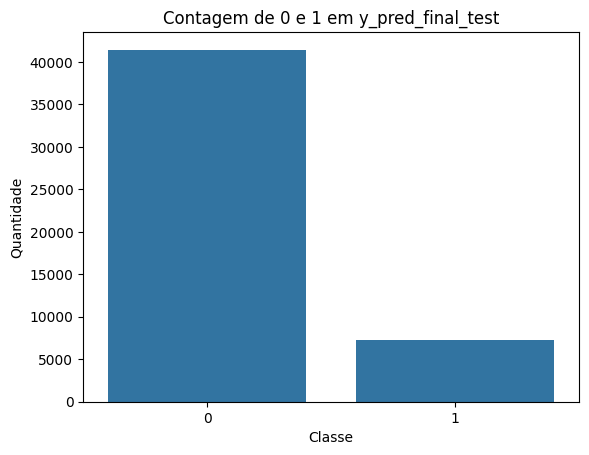

In [103]:
# Plotando a quantidade de 0s e 1s em y_pred_final_test
sns.countplot(x=y_pred_final_test)
plt.title("Contagem de 0 e 1 em y_pred_final_test")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.show()

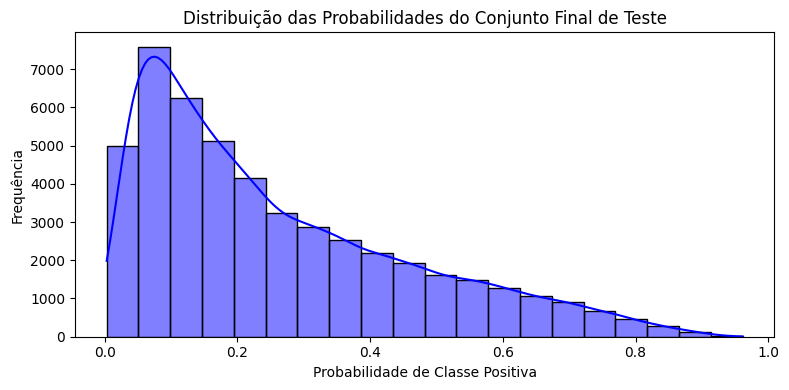

In [104]:
# Plotando a distribuição das probabilidades
plt.figure(figsize=(8, 4))
sns.histplot(y_prob_final_test, bins=20, kde=True, color='blue')
plt.title("Distribuição das Probabilidades do Conjunto Final de Teste")
plt.xlabel("Probabilidade de Classe Positiva")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# that's all folks...